In [1]:

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import random
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.svm import NuSVR
from sklearn.metrics import normalized_mutual_info_score

In [7]:
#data[0] data[1]  data[2]  data[3]    data[4]    data[5]     data[6]   data[7]    data[8]    data[9]      data[10]   data[11]     data[12]              
# time region_id rgn_prg rgn_runtime energy_pkg energy_dram power_pkg power_dram frequency cycles_thread cycles_ref inst-retired dram-throttle-time

## 100 miliseconds
time_granularity = 0

## Make a list of the files
file_list = glob.glob("/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench*")

#randomize the file list
#random.shuffle(file_list)
file_list = random.sample(file_list,300)

#checks validity of a row, i.e. each data point should 
def is_valid(data):
    validity = 1
    for pt in data:
        if pt == 'nan':
            validity = 0
           
    if validity ==1:
        return True
    else:
        return False

# converts str to floats, modify region id
def process_line(data):
    
    for idx in range(len(data)):
        if idx != 1:
            data[idx] = float(data[idx])
        else:
            if data[1] == '0x2000000000000000':
                data[1] = 6e9
            elif data[1] == '0x8000000000000000':
                data[1] = 5e9
            else:
                data[1] = int(data[1], 16)

    return np.asarray(data)


# defines features from float values
def feature_row(line1, line2):
    return np.array([line2[0]-line1[0],line2[1],line2[2],line2[3],line2[4],line2[5],line2[6],line2[7],line2[8], line2[9],line2[10]])


#time,region_id,energy_package,energy_dram,power_package,power_dram,frequency,cycles_thread,cycles_reference,inst-retired,time_diff    
labels = np.array(['time', 'region_id','energy_pkg', 'energy_dram', 'power_pkg', 'power_dram', 'frequency',
                   'cycles_thread', 'cycles_ref', 'inst-retired', 'time-diff'])



df = pd.DataFrame()
first_stack = True
for i in range(len(file_list)):
    line1= []
    line2 = []       
    line_no = 0
    isfirst = True
    row = []
    data = []
    with open(file_list[i]) as f:
        print(f)
        for _ in range(9):
            next(f)
        for rows in f:
                
            line = rows.split(',');
        
            if is_valid(line):
                    
                if line1 ==[]:
                    line1 = process_line(line)
                
                elif float(line[0])-line1[0] > time_granularity:
                            
                    if line2 == []:
                        line2 = process_line(line)
                        row = feature_row(line1, line2)
                    else:
                        line1 = line2
                        line2 = process_line(line)
                        row = feature_row(line1, line2)
                        
                    if isfirst:
                        isfirst = False
                        data = row
                    else:
                            ## check if this operation is efficient
                        data = np.vstack([data, row])
    #print(data[0])
        
    if first_stack:
        df = pd.DataFrame(data, columns =labels)
        #df = clean(df)
        df.drop_duplicates('time', keep='first', inplace =True)
        df = df[df['time'] > 0.005]
        
        df['energy_pkg'] = df['energy_pkg']/df['time']
        df['energy_dram'] = df['energy_dram']/df['time']
        df['cycles_thread'] = df['cycles_thread']/df['time']
        df['inst-retired'] = df['inst-retired']/df['time']
               
        df['power_pkg_next'] = df['power_pkg'].shift(-1)
        df['power_dram_next'] = df['power_dram'].shift(-1)
        df['frequency_next'] = df['frequency'].shift(-1)
        df.drop(df.index[len(df)-1], inplace= True)
        #df.drop(df.index[len(df)-1]
        first_stack = False

    else:
        df1 = pd.DataFrame(data, columns =labels)
        df1.drop_duplicates('time', keep='first', inplace =True)
        df1 = df1[df1['time'] > 0.005]
        
        df1['energy_pkg'] = df1['energy_pkg']/df1['time']
        df1['energy_dram'] = df1['energy_dram']/df1['time']
        df1['cycles_thread'] = df1['cycles_thread']/df1['time']
        df1['inst-retired'] = df1['inst-retired']/df1['time']
        
        df1['power_pkg_next'] = df1['power_pkg'].shift(-1)
        df1['power_dram_next'] = df1['power_dram'].shift(-1)
        df1['frequency_next'] = df1['frequency'].shift(-1)
        df1.drop(df1.index[len(df1)-1], inplace = True)
        
        df= pd.concat([df,df1])
        print(df.shape)
        line_no +=1


<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench207_2_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench290_0_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(799, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench250_2_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(1309, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench244_0_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(1455, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench224_2_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(1890, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench9_2_trace

/home/snowcrash/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/home/snowcrash/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


(4079, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench44_2_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(4391, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench245_1_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(4885, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench197_0_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(5118, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench149_1_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(5686, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench184_1_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(5821, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/

(22647, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench164_2_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(22779, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench197_2_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(23017, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench74_0_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(23269, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench166_1_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(23685, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench182_2_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(24078, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year

(40388, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench278_0_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(40517, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench245_2_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(41004, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench63_2_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(41560, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench51_0_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(42088, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench68_1_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(42649, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_g

(58211, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench169_0_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(58372, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench66_0_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(58819, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench273_2_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(59343, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench183_0_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(59823, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench282_2_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(60212, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year

(73930, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench192_1_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(74286, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench221_0_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(74558, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench228_1_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(74813, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench205_1_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(75293, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench187_2_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(75814, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_yea

(88882, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench18_2_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(89089, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench150_0_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(89566, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench187_0_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(90082, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench298_0_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(90295, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year_gift/pre1/geobench157_0_trace-mpp3r03c05s04' mode='r' encoding='UTF-8'>
(90557, 14)
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/trace_analysis/new_data_12jan/new_year

In [9]:
print(df.shape)
from scipy import stats

## remove elements greater than 3-sigma Zscore
z = np.abs(stats.zscore(df))
print(z)
df = df[(z < 3).all(axis=1)]
print(df.shape)

(99555, 14)
[[0.24267597 1.08520468 0.06041673 ... 0.20602966 1.70918862 1.27520927]
 [0.06801805 1.08520468 0.68607467 ... 0.29311263 1.84120374 1.64084777]
 [0.00767728 1.08520468 0.05115667 ... 0.43600863 1.91447256 1.64084777]
 ...
 [0.00759313 1.16577788 0.20221567 ... 0.38673004 1.00912267 1.64084777]
 [0.05795511 1.16577788 0.16153405 ... 0.17614208 1.00162968 1.27520927]
 [3.21676532 1.16577788 0.1504929  ... 0.41772836 0.99892477 1.27520927]]
(97785, 14)


(97785, 14)


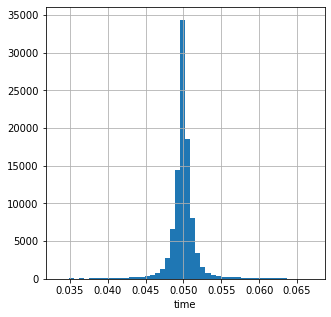

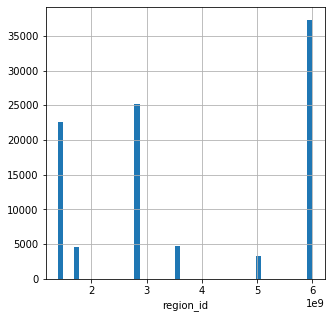

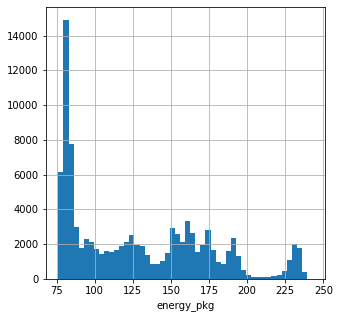

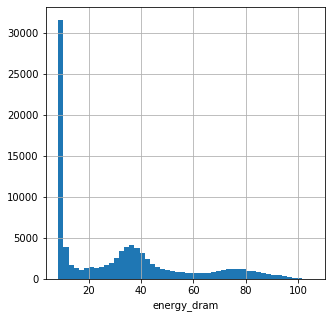

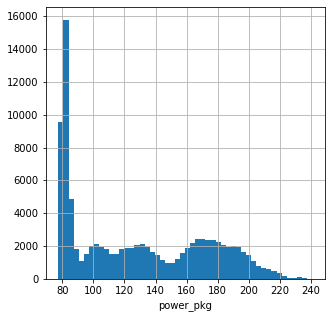

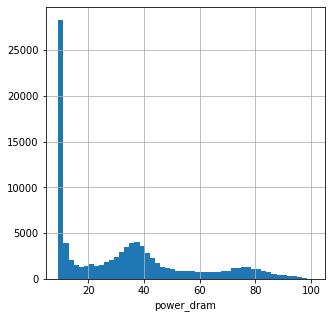

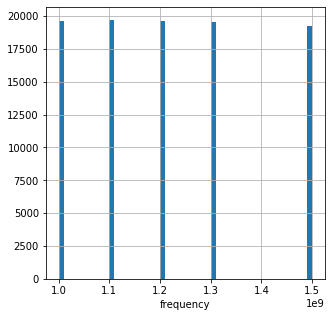

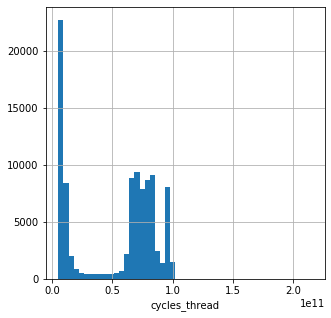

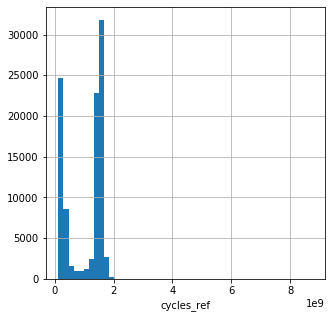

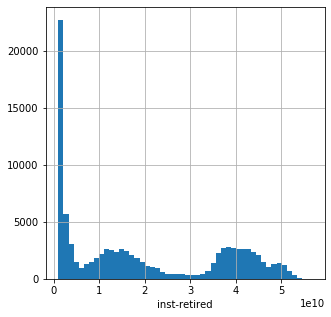

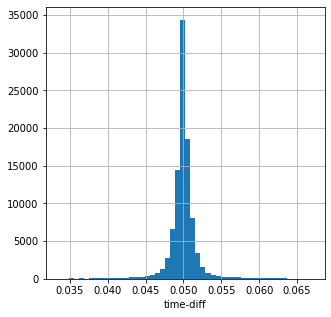

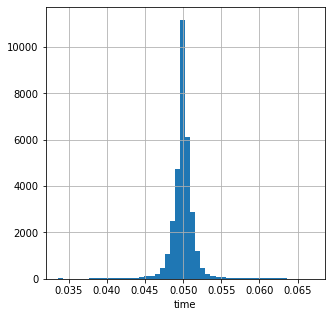

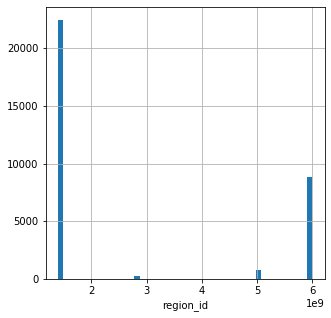

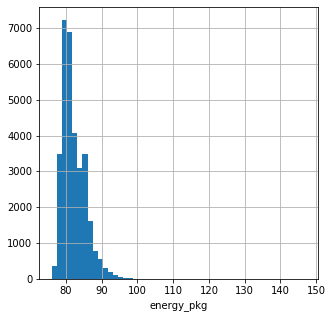

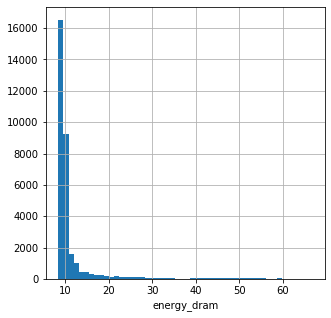

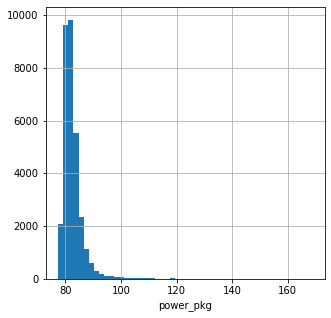

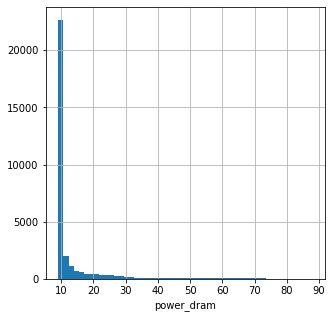

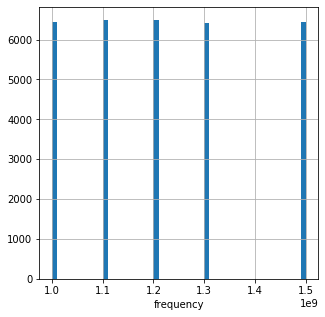

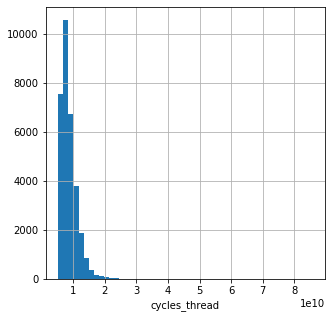

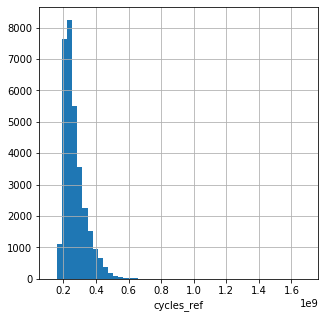

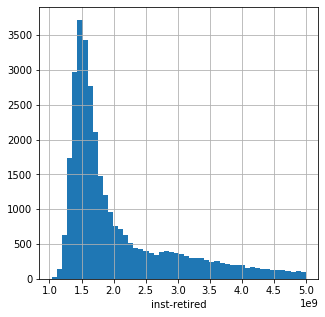

In [10]:
#data[0] data[1]  data[2]  data[3]    data[4]    data[5]     data[6]   data[7]    data[8]    data[9]      data[10]   data[11]     data[12]              
# time region_id rgn_prg rgn_runtime energy_pkg energy_dram power_pkg power_dram frequency cycles_thread cycles_ref inst-retired dram-throttle-time
df1 = df
df_low = df[df['inst-retired'] <= 0.5e10]

print(df.shape)

for i in range(11):
    series = pd.Series(df[labels[i]].values,index=df['time'])
    fig = plt.gcf()
    fig.set_size_inches(5, 5)  
    series.hist(bins = 50)
    plt.xlabel(labels[i])
    plt.show()
    fig.savefig(labels[i], dpi=100)
    
for i in range(10):
    series = pd.Series(df_low[labels[i]].values,index=df_low['time'])
    fig = plt.gcf()
    fig.set_size_inches(5, 5)  
    series.hist(bins = 50)
    plt.xlabel(labels[i])
    plt.show()
    fig.savefig(labels[i], dpi=100)

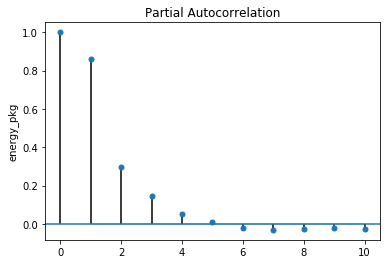

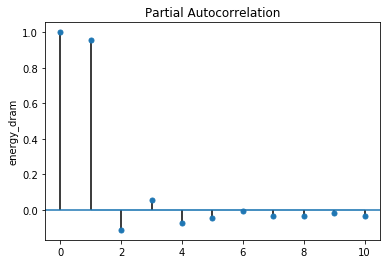

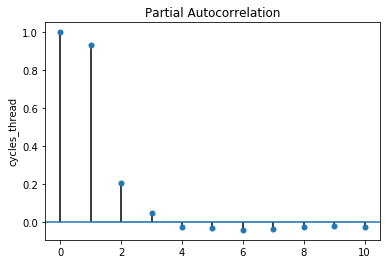

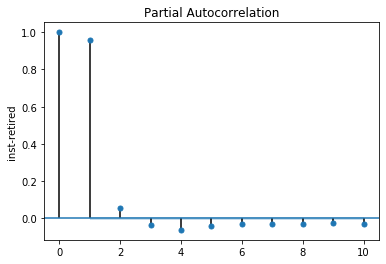

In [12]:
for label in labels:

    plot_pacf(df[label], lags=10)
    plt.ylabel(label)
    plt.show()

KeyError: 'rgn_runtime'

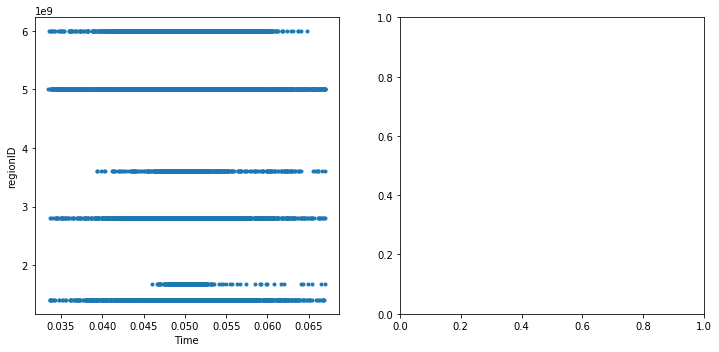

In [14]:
#data[0] data[1]  data[2]  data[3]    data[4]    data[5]     data[6]   data[7]    data[8]    data[9]      data[10]   data[11]     data[12]              
# time region_id rgn_prg rgn_runtime energy_pkg energy_dram power_pkg power_dram frequency cycles_thread cycles_ref inst-retired dram-throttle-time

fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.subplot(2,2,1)
plt.plot(df['time'], df['region_id'],'.')
plt.xlabel('Time')
plt.ylabel('regionID')
plt.subplot(2,2,2)
plt.plot(df['time'], df['rgn_runtime'],'.')
plt.xlabel('Time')
plt.ylabel('region runtime')
plt.subplot(2,2,3)
plt.plot(df['time'], df['energy_pkg'],'.')
plt.xlabel('Time')
plt.ylabel('energy pkg')
plt.subplot(2,2,4)
plt.plot(df['time'], df['energy_dram'],'.')
plt.xlabel('Time')
plt.ylabel('energy dram')
fig.savefig('twopower_runs_1', dpi=100)
plt.show()

fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.subplot(2,2,1)
plt.plot(df['time'], df['power_pkg'],'.')
plt.xlabel('Time')
plt.ylabel('power pkg')
plt.subplot(2,2,2)
plt.plot(df['time'], df['power_dram'],'.')
plt.xlabel('Time')
plt.ylabel('power dram')
plt.subplot(2,2,3)
plt.plot(df['time'], df['frequency'],'.')
plt.xlabel('Time')
plt.ylabel('frequency')
plt.subplot(2,2,4)
plt.plot(df['power_pkg'], df['cycles_thread'],'.')
plt.xlabel('power pkg')
plt.ylabel('cycles thread')
fig.savefig('twopower_runs_2', dpi=100)
plt.show()

fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.subplot(2,2,1)
plt.plot(df['power_pkg'], df['inst-retired'],'.')
plt.xlabel('power pkg')
plt.ylabel('instructions retired')
plt.subplot(2,2,2)
plt.plot(df['power_pkg'], df['cycles_thread']/df['inst-retired'],'.')
plt.xlabel('Time')
plt.ylabel('cycles per instruction')
plt.subplot(2,2,3)
plt.plot(df['power_pkg'], df['frequency'],'.')
plt.xlabel('energy pkg')
plt.ylabel('frequency')
plt.subplot(2,2,4)
plt.plot(df['energy_dram'], df['power_dram'],'.')
plt.xlabel('energy dram')
plt.ylabel('power*time')
plt.show()
fig.savefig('twopower_runs_2', dpi=100)

In [16]:
df['frequency'] = df['frequency'].shift(1)
df = df.dropna()

/home/snowcrash/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
#df_sleep = df[df['region_id'] == int('0x00000000536c798f', 16)]
#df_init = df[df['region_id'] == int('0x00000000644f9787', 16)]
#df_dgemm = df[df['region_id'] == int('0x00000000a74bbf35', 16)]
#df_stream = df[df['region_id'] == int('0x00000000d691da00', 16)]
#df_unmarked = df[df['region_id'] == 6e9]
#df_epoch = df[df['region_id'] == 5e9]

df_sleep = df[df['region_id'] == int('0x00000000536c798f', 16)]
df_init = df[df['region_id'] == int('0x00000000644f9787', 16)]
df_dgemm = df[df['region_id'] == int('0x00000000a74bbf35', 16)]
df_stream = df[df['region_id'] == int('0x00000000d691da00', 16)]
df_unmarked = df[df['region_id'] == 0]
df_epoch = df[df['region_id'] == 0]
#df= df[df['region_id'] !=int('0x00000000536c798f', 16)]
print(df.shape)

(97784, 14)


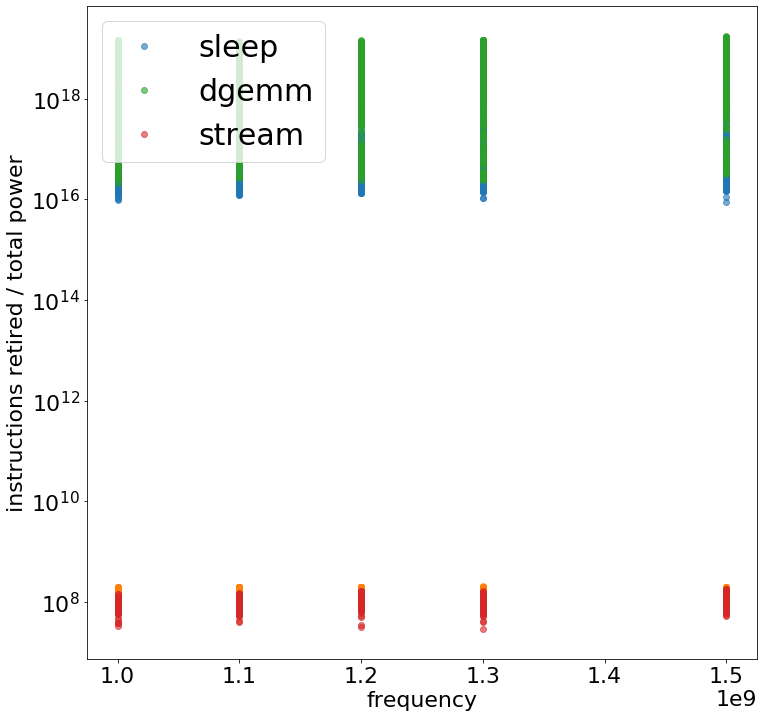

In [18]:
#data[0] data[1]  data[2]  data[3]    data[4]    data[5]     data[6]   data[7]    data[8]    data[9]      data[10]   data[11]     data[12]              
# time region_id rgn_prg rgn_runtime energy_pkg energy_dram power_pkg power_dram frequency cycles_thread cycles_ref inst-retired dram-throttle-time

matplotlib.rcParams.update({'font.size': 22})
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.plot(df_sleep['frequency'], df_sleep['inst-retired']**2/(df_sleep['energy_pkg']+ df_sleep['energy_dram']),'o',label = 'sleep', alpha = 0.6)
plt.plot(df_init['frequency'], df_init['inst-retired']/(df_init['energy_pkg']),'o', alpha = 0.3)
plt.plot(df_dgemm['frequency'], df_dgemm['inst-retired']**2/(df_dgemm['power_pkg']), 'o',label = 'dgemm', alpha = 0.6)
plt.plot(df_stream['frequency'], df_stream['inst-retired']/(df_stream['power_dram']+df_stream['power_pkg']), 'o',label = 'stream', alpha = 0.6)
plt.plot(df_unmarked['frequency'], df_unmarked['inst-retired']/(df_unmarked['power_dram']+df_unmarked['power_pkg']),'o', alpha = 0.3)
plt.plot(df_epoch['frequency'], df_epoch['inst-retired']/(df_epoch['power_dram']+df_epoch['power_pkg']),'o', alpha = 0.3)
plt.legend()
plt.yscale('log')
plt.legend(loc=2, prop={'size': 30})
plt.xlabel('frequency')
plt.ylabel('instructions retired / total power')
fig.savefig('region_dram', dpi=100)
plt.show()

In [45]:
df[df['time']>5.5]

time     region_id  rgn_runtime  energy_pkg  energy_dram  \
77    5.505006  2.806759e+09     0.000000    1.414695     0.368683   
78    5.554965  2.806759e+09     0.000000    1.407828     0.386364   
79    5.604958  2.806759e+09     0.000000    1.401619     0.382973   
80    5.655065  2.806759e+09     0.000000    1.388725     0.410480   
81    5.704907  2.806759e+09     0.000000    1.352766     0.363703   
82    5.755037  2.806759e+09     0.000000    1.379163     0.663248   
83    5.813372  2.806759e+09     0.000000    1.582602     0.771337   
84    5.855168  2.806759e+09     0.000000    1.059438     0.520447   
85    5.905080  2.806759e+09     0.000000    1.247333     0.610994   
86    5.962595  2.806759e+09     0.000000    1.436763     0.691629   
87    6.004969  2.806759e+09     0.000000    1.224338     0.568082   
88    6.054990  2.806759e+09     0.000000    1.387169     0.637932   
89    6.104857  2.806759e+09     0.000000    1.404131     0.631581   
90    6.154915  2.806759e+09     0.000000    1.396262     0.628269   
91    6.204874  2.806759e+09     0.000000    1.378518     0.662223   
92    6.254999  2.806759e+09     0.000000    1.372984     0.620148   
93    6.304955  2.806759e+09     0.000000    1.333635     0.607481   
94    6.355034  2.806759e+09     0.000000    1.352466     0.647171   
95    6.412294  2.806759e+09     0.000000    1.554307     0.735158   
96    6.455005  2.806759e+09     0.000000    1.121467     0.516033   
97    6.512610  2.806759e+09     0.000000    1.505896     0.665776   
98    6.554974  2.806759e+09     0.000000    1.045870     0.523489   
99    6.605136  2.806759e+09     0.000000    1.200774     0.585066   
100   6.655067  2.806759e+09     0.000000    1.166287     0.571808   
101   6.712669  2.806759e+09     0.000000    1.385856     0.662182   
102   6.754926  2.806759e+09     0.000000    1.068791     0.527953   
103   6.806046  2.806759e+09     2.352250    1.274887     0.631780   
105   6.862107  2.806759e+09     2.490021    1.278659     0.768042   
107   6.909438  2.806759e+09     2.490021    0.828715     0.618457   
109   6.955023  2.806759e+09     2.490021    0.866573     0.605146   
..         ...           ...          ...         ...          ...   
282  14.577151  6.000000e+09     1.071137    0.368192     0.222529   
283  14.627878  6.000000e+09     1.071137    0.425430     0.223643   
284  14.678509  6.000000e+09     1.051682    0.365545     0.162649   
285  14.727664  6.000000e+09     0.000116    0.306136     0.085069   
286  14.776858  6.000000e+09     0.000116    0.302667     0.072188   
287  14.843224  6.000000e+09     0.000116    0.409792     0.098404   
288  14.876897  6.000000e+09     0.000116    0.216437     0.054016   
289  14.926978  6.000000e+09     0.000116    0.315595     0.078286   
290  14.976930  6.000000e+09     0.000116    0.307321     0.076937   
291  15.026894  6.000000e+09     0.000116    0.314122     0.081645   
292  15.076890  6.000000e+09     0.000116    0.314457     0.085216   
293  15.126832  6.000000e+09     0.000116    0.313075     0.082417   
294  15.176868  6.000000e+09     0.000116    0.311360     0.085435   
295  15.226877  6.000000e+09     0.000116    0.308509     0.081342   
296  15.276874  6.000000e+09     0.000116    0.304931     0.082702   
297  15.345422  6.000000e+09     0.000116    0.423957     0.110246   
298  15.376933  6.000000e+09     0.000116    0.189548     0.046504   
299  15.426936  6.000000e+09     0.000116    0.304884     0.075559   
300  15.494044  6.000000e+09     0.000116    0.410672     0.098994   
301  15.541952  6.000000e+09     0.000116    0.318945     0.074839   
302  15.576726  6.000000e+09     0.000116    0.254391     0.053380   
303  15.626759  6.000000e+09     0.000116    0.370302     0.078565   
304  15.676738  6.000000e+09     0.000116    0.368752     0.074176   
305  15.726743  6.000000e+09     0.000116    0.368076     0.074414   
306  15.791889  6.000000e+09     0.000116    0.477107     0.096767   
307  15.826836  6.00

In [46]:
df1 = df
df = df.iloc[77:107]

In [59]:
# Normalize the data
#sleep
#df = df[df['region_id'] == int('0x00000000536c798f', 16)]
#dgemm
#df = df[df['region_id'] == int('0x00000000a74bbf35', 16)]
#stream
#df = df[df['region_id'] == int('0x00000000d691da00', 16)]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
labels = ['time', 'region_id', 'energy_pkg', 'energy_dram', 'power_pkg', 'power_dram', 'frequency', 'cycles_thread', 'cycles_ref', 'inst-retired','power_pkg_next','power_dram_next','frequency_next' ]
df = pd.DataFrame(scaler.fit_transform(df.values),columns =labels)
print(df.head())

       time  region_id  energy_pkg  energy_dram  power_pkg  power_dram  \
0 -0.102791  -1.076942    0.905579     0.956630   0.644682   -0.022846   
1  0.224873  -1.076942    0.807621     1.232129   0.702688    0.223357   
2 -0.108593  -1.076942   -0.125699     1.121174   0.587913    0.488715   
3  0.179026  -1.076942    0.781933     2.529013   0.452410    0.865864   
4  0.218166  -1.076942    0.102426     2.286452   0.323594    1.262545   

   frequency  cycles_thread  cycles_ref  inst-retired  power_pkg_next  \
0   1.635972       1.269155    0.788870      0.737754        0.703901   
1  -1.279893       1.247282    0.792173      0.346195        0.589084   
2   1.635972       0.442750    0.770509     -0.437774        0.453531   
3  -0.113547       1.261285    0.791154     -0.188706        0.324668   
4  -0.113547       0.701651    0.841038     -0.356783        0.343470   

   power_dram_next  frequency_next  
0         0.227194       -1.278365  
1         0.492085        1.638456  
2    

In [9]:
print(normalized_mutual_info_score(df['power_pkg'], df['frequency']))
print(normalized_mutual_info_score(df['power_pkg'], df['inst-retired']))
print(normalized_mutual_info_score(df['power_pkg'], df['cycles_thread']))
print(normalized_mutual_info_score(df['power_dram'], df['frequency']))
print(normalized_mutual_info_score(df['power_dram'], df['inst-retired']))
print(normalized_mutual_info_score(df['power_dram'], df['cycles_thread']))

0.35766577442790237
1.0
1.0
0.35766577442790237
1.0
1.0


In [131]:
df = df1

(97979, 5)
(97979,)
(78383, 4)
(78383,)
(19596, 4)
(19596,)


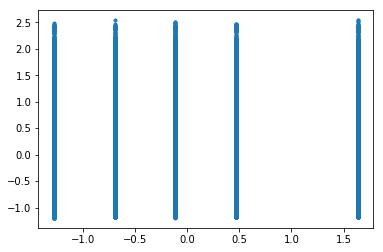

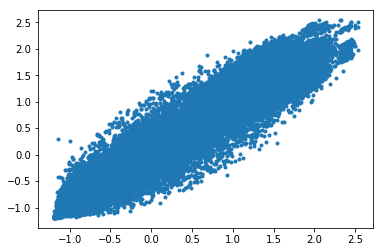

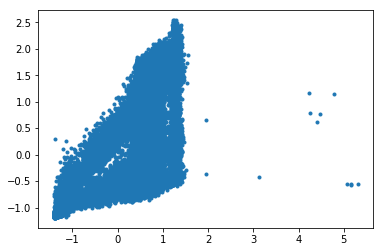

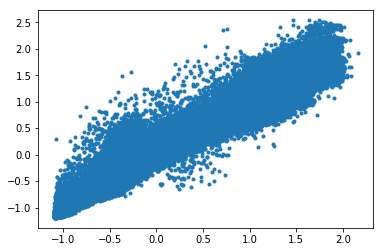

In [60]:


X_data= np.transpose(np.array([ df['frequency_next'],df['power_pkg'], df['cycles_thread'], df['inst-retired'], df['region_id']]))
y_data = np.ravel(np.transpose(np.array([df['power_pkg_next'] ]) ))
print(X_data.shape)
print(y_data.shape)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

region_test = X_test[:,4]
X_train = np.delete(X_train, 4, 1)
X_test = np.delete(X_test, 4, 1)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

plt.plot(X_train[:,0],y_train,'.')
plt.show()
plt.plot(X_train[:,1],y_train,'.')
plt.show()
plt.plot(X_train[:,2],y_train,'.')
plt.show()
plt.plot(X_train[:,3],y_train,'.')
plt.show()

(0, 5)
(0,)
(0, 4)
(0,)
(0, 4)
(0,)


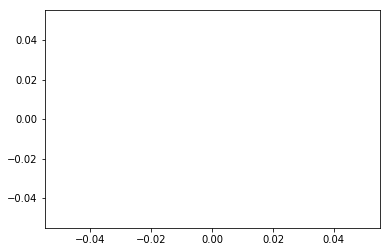

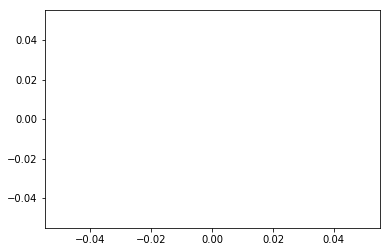

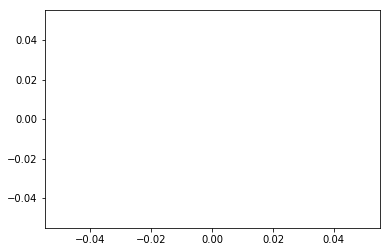

In [133]:
X_data= np.transpose(np.array([df['frequency_next'], df['power_dram'], df['cycles_thread'], df['inst-retired'], df['region_id']]))
y_data = np.ravel(np.transpose(np.array([df['power_dram_next'] ]) ))
print(X_data.shape)
print(y_data.shape)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42)

region_test = X_test[:,4]
X_train = np.delete(X_train, 4, 1)
X_test = np.delete(X_test, 4, 1)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)



plt.plot(X_train[:,0],y_train,'.')
plt.show()
plt.plot(X_train[:,1],y_train,'.')
plt.show()
plt.plot(X_train[:,2],y_train,'.')
plt.show()


In [61]:
from sklearn import linear_model
from sklearn import gaussian_process

In [62]:
####LEAST SQUARES REGRESSION ####

#import math
#error = math.sqrt(np.mean( (y_predict- y_test)**2 ))
#w = np.linalg.solve(np.matmul(np.transpose(X_train),X_train)+reg_strength*np.identity(X_train.shape[1]), np.matmul(np.transpose(X_train),y_train)  )
#y_predict = np.matmul(X_test, w)
#least_error =1
#for reg_strength in reg:


### Linear Regression ##
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
accuracy = np.mean(np.absolute((y_pred_lin- y_test)/y_test))

print('Linear regression:')
print('Training R2:', lin_reg.score(X_train, y_train))
print('Validation R2:' ,lin_reg.score(X_test, y_test))
print('L1 accuracy:', accuracy)
print(lin_reg.coef_)


### Ridge regression###
reg = 10
ridge_reg = linear_model.Ridge(alpha=reg)
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)
accuracy = 1 - np.mean(np.absolute((y_pred_ridge- y_test)/y_test))
print('Ridge regression:')
print('Training R2:', ridge_reg.score(X_train, y_train))
print('Validation R2:' ,ridge_reg.score(X_test, y_test))
print('L1 accuracy:', accuracy)
print(ridge_reg.coef_)


### Lasso ###
regs = [1,8e-1,1e-1,1.2e-1,5e-2,1e-2]
acc = -100
best_lasso = []
for reg in regs:
    lasso_reg = linear_model.Lasso(alpha=reg).fit(X_train, y_train)
    y_pred_lasso = lasso_reg.predict(X_test)
    accuracy = np.mean(np.absolute((y_pred_lasso- y_test)/y_test))
    if accuracy > acc:
        acc = accuracy
        best_lasso = lasso_reg
#print(best_lasso)

y_pred_lasso = best_lasso.predict(X_test)
accuracy = 1 - np.mean(np.absolute((y_pred_lasso- y_test)/y_test))
print('Lasso regression:')
print('Training R2:', best_lasso.score(X_train, y_train))
print('Validation R2:' ,best_lasso.score(X_test, y_test))
print('L1 accuracy:', accuracy)
print(lasso_reg.coef_)

'''
### TheilSen ###
theil_reg = linear_model.TheilSenRegressor().fit(X_train, y_train)
y_pred_theil = theil_reg.predict(X_test)
accuracy = 1 - np.mean(np.absolute((y_pred_theil- y_test)/y_test))
print('Theil regression:')
print('Training R2:', theil_reg.score(X_train, y_train))
print('Validation R2:' ,theil_reg.score(X_test, y_test))
print('L1 accuracy:', accuracy)
print(theil_reg.coef_)
'''

### Huber ###
huber_reg = linear_model.HuberRegressor(epsilon=1.35, max_iter=100, alpha=0.0001, warm_start=False, fit_intercept=True, tol=1e-05).fit(X_train, y_train)
y_pred_huber = huber_reg.predict(X_test)
accuracy = 1 - np.mean(np.absolute((y_pred_huber- y_test)/y_test))
print('Huber regression:')
print('Training R2:', huber_reg.score(X_train, y_train))
print('Validation R2:' ,huber_reg.score(X_test, y_test))
print('L1 accuracy:', accuracy)
print(huber_reg.coef_)


### Bayes ridge ###
bayes_reg = linear_model.BayesianRidge().fit(X_train, y_train)
y_pred_bayes = bayes_reg.predict(X_test)
accuracy = np.mean(np.absolute((y_pred_bayes- y_test)/y_test))
print('Bayes regression:')
print(accuracy)
print(bayes_reg.coef_)


#gauss_reg = gaussian_process.GaussianProcessRegressor().fit(X_train, y_train)
#y_pred_gauss = gauss_reg.predict(X_test)
#accuracy = 1 - np.mean(np.absolute((y_pred_gauss- y_test)/y_test))
#print('Gauss regression:')
#print(accuracy)
#print(gauss_reg.coef_)


Linear regression:
Training R2: 0.9688130597896171
Validation R2: 0.9688117890452543
L1 accuracy: 0.7126502976125169
[0.00982047 0.51902357 0.07044623 0.41811894]
Ridge regression:
Training R2: 0.968813049875104
Validation R2: 0.9688117056511373
L1 accuracy: 0.28735507925735504
[0.00981968 0.51878618 0.07055376 0.41820941]
Lasso regression:
Training R2: 0.0
Validation R2: -7.371271211642494e-05
L1 accuracy: -0.001921364988388241
[0.         0.51736989 0.06508762 0.4138915 ]
Huber regression:
Training R2: 0.9682058646129573
Validation R2: 0.9681938345465666
L1 accuracy: 0.289440392001989
[0.00771494 0.54265295 0.05194919 0.39930073]
Bayes regression:
0.7126501468776674
[0.00982045 0.51901696 0.07044922 0.41812146]


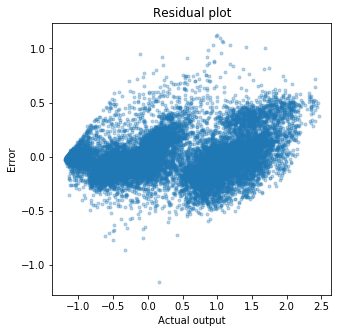

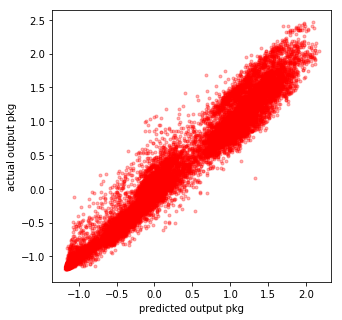

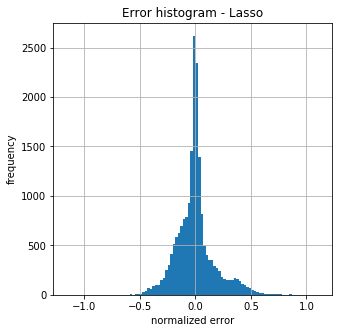

In [63]:
y_predict = y_pred_ridge
error = y_test - y_pred_ridge

fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.plot(y_test, error,'.', alpha = 0.3)

plt.xlabel('Actual output')
plt.ylabel('Error')
plt.title('Residual plot')
plt.show()
fig.savefig('residual_lin', dpi=100)

fig = plt.gcf() 
fig.set_size_inches(5, 5)
plt.plot(y_predict, y_test,'r.', alpha = 0.3)
plt.xlabel('predicted output pkg')
plt.ylabel('actual output pkg')
plt.show()


series = pd.Series(error)
fig = plt.gcf()
fig.set_size_inches(5, 5)  
series.hist(bins = 100)
plt.xlabel('normalized error')
plt.ylabel('frequency')
plt.title('Error histogram - Lasso')
plt.show()
fig.savefig('error_lin', dpi=100)

In [ ]:

best_svr = []
best_error = 10
Nu_lst = [0.5,0.75]
c_lst = [1,10]
kernel_lst =['rbf']
for kern in kernel_lst:
    for Nu in Nu_lst:
        for c in c_lst:
            svr = NuSVR(nu=Nu, C=c, kernel=kern, coef0=0.0, verbose=False, max_iter=-1)
            svr.fit(X_train, y_train)  
            y_predict = svr.predict(X_test)
            e = np.mean(np.absolute((y_predict- y_test)/y_test))
            print(kern, Nu, c)
            print(e)
            if best_error>e:
                best_error = e
                best_svr = svr
        

In [12]:
print(best_svr.get_params(deep=True))

{'C': 10, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'nu': 0.75, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [10]:
svr = NuSVR(nu=0.75, C=10, kernel='rbf', coef0=0.0, verbose=False, max_iter=10000)
svr.fit(X_train, y_train)  
y_predict = svr.predict(X_test)
e = np.mean(np.absolute((y_predict- y_test)/y_test))
print(e)
print(svr.get_params(deep=True))

best_svr = svr

y_predict = best_svr.predict(X_test)

/home/snowcrash/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


1.1625921518046012
{'C': 10, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 10000, 'nu': 0.75, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [ ]:
error = y_predict - y_test

plt.plot(region_test, error,'.')
plt.show()

fig = plt.gcf() 
fig.set_size_inches(5, 5)
plt.plot(y_predict, y_test,'r.')
plt.xlabel('predicted output pkg')
plt.ylabel('actual output pkg')
plt.show()
tu
print(error)

series = pd.Series(error)
fig = plt.gcf()
fig.set_size_inches(5, 5)  
series.hist(bins = 100)
plt.xlabel(error)
plt.show()
fig.savefig('error', dpi=100)

error = np.mean(np.absolute((y_predict- y_test)/y_test))
print(error)

In [18]:
f = np.array([1e9,1.1e9,1.2e9,1.3e9,1.5e9])
std = np.std(X_test)
mean = np.mean(X_test)

for n in range(X_test.shape[0]):
    energy_min = 1e15
    best_i = 10
    for i in range(5):
        X_test[n,1] = f[i]
        energy = ridge_reg.predict(X_test[n,].reshape(-1, 4))
        print(i,energy)
        if energy<energy_min:
            energy_min = energy
            best_i = i
    
'''
for i in range(5):
    X_test[:,1] = np.ones(X_test.shape[0])*f[i]
    energy = best_svr.predict(X_test)
    print(energy)
'''   
    

0 [6.09730578e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649733e+08]
4 [9.14595835e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730581e+08]
1 [6.70703633e+08]
2 [7.31676684e+08]
3 [7.92649736e+08]
4 [9.14595838e+08]
0 [6.09730587e+08]
1 [6.70703638e+08]
2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676664e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649696e+08]
4 [9.14595799e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]

0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595803e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730581e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676664e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676684e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730575e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.9264973e+08]
4 [9.14595833e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730563e+08]
1 [6.70703615e+08]
2 [7.31676666e+08

1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730599e+08]
1 [6.70703651e+08]
2 [7.31676702e+08]
3 [7.92649754e+08]
4 [9.14595857e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730587e+08]
1 [6.70703639e+08]
2 [7.3167669e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730586e+08]
1 [6.70703638e+08]
2 [7.31676689e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.0973056e+08]
1 [6.70703612e+08]
2 [7.31676663e+08]
3 [7.92649715e+08]
4 [9.14595817e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730577e+08]
1 [6.70703629e+08]
2 [7.3167668e+08]
3 [7.92649732e+08]
4 

4 [9.14595803e+08]
0 [6.09730574e+08]
1 [6.70703626e+08]
2 [7.31676677e+08]
3 [7.92649729e+08]
4 [9.14595831e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.3167668e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 

0 [6.09730551e+08]
1 [6.70703603e+08]
2 [7.31676654e+08]
3 [7.92649706e+08]
4 [9.14595808e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730587e+08]
1 [6.70703638e+08]
2 [7.31676689e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730584e+08]
1 [6.70703636e+08]
2 [7.31676687e+08]
3 [7.92649739e+08]
4 [9.14595841e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730595e+08]
1 [6.70703646e+08]
2 [7.31676698e+08]
3 [7.92649749e+08]
4 [9.14595852e+08]
0 [6.09730568e+08]
1 [6.70703619e+08]
2 [7.31676671e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730574e+08]
1 [6.70703626e+08]
2 [7.31676677e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730584e+08]
1 [6.70703636e+08]
2 [7.31676687e+08]
3 [7.92649739e+08]
4 [9.14595841e+08]
0 [6.09730584e+08]
1 [6.70703636e+08]
2 [7.31676687e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730557e+08]
1 [6.70703608e+08]
2 [7.3167666e+

0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730561e+08]
1 [6.70703613e+08]
2 [7.31676664e+08]
3 [7.92649716e+08]
4 [9.14595818e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730581e+08]
1 [6.70703632e+08]
2 [7.31676684e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730548e+08]
1 [6.70703599e+08]
2 [7.3167665e+08]
3 [7.92649702e+08]
4 [9.14595805e+08]
0 [6.09730547e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.0973059e+08]
1 [6.70703641e+08]
2 [7.31676693e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595836e+08]
0 [6.09730571e+08]
1 [6.70703623e+08]
2 [7.31676674e+08]
3 [7.92649726e+08]
4 [9.14595828e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730574e+08]
1 [6.70703626e+08]
2 [7.31676677e+

4 [9.14595801e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730589e+08]
1 [6.7070364e+08]
2 [7.31676692e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730588e+08]
1 [6.70703639e+08]
2 [7.31676691e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730588e+08]
1 [6.70703639e+08]
2 [7.31676691e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730584e+08]
1 [6.70703635e+0

4 [9.14595798e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730565e+08]
1 [6.70703616e+08]
2 [7.31676668e+08]
3 [7.92649719e+08]
4 [9.14595822e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676687e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730598e+08]
1 [6.7070365e+08]
2 [7.31676701e+08]
3 [7.92649753e+08]
4 [9.14595856e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]

1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676663e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595807e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9

3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730571e+08]
1 [6.70703623e+08]
2 [7.31676674e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730561e+08]
1 [6.70703613e+08]
2 [7.31676664e+08]
3 [7.92649716e+08]
4 [9.14595818e+08]
0 [6.09730591e+08]
1 [6.70703643e+08]
2 [7.31676694e+08]
3 [7.92649746e+08]
4 [9.14595848e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.1459583e+08]
0 [6.09730567e+08]


1 [6.70703622e+08]
2 [7.31676674e+08]
3 [7.92649725e+08]
4 [9.14595828e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730555e+08]
1 [6.70703606e+08]
2 [7.31676658e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730577e+08]
1 [6.70703628e+08]
2 [7.3167668e+08]
3 [7.92649731e+08]
4 [9.14595834e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.0973056e+08]
1 [6.70703612e+08]
2 [7.31676663e+08]
3 [7.92649715e+08]

0 [6.09730542e+08]
1 [6.70703593e+08]
2 [7.31676644e+08]
3 [7.92649696e+08]
4 [9.14595799e+08]
0 [6.09730547e+08]
1 [6.70703599e+08]
2 [7.3167665e+08]
3 [7.92649702e+08]
4 [9.14595805e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730581e+08]
1 [6.70703632e+08]
2 [7.31676684e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730568e+08]
1 [6.70703619e+08]
2 [7.31676671e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]

3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676677e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730591e+08]
1 [6.70703643e+08]
2 [7.31676694e+08]
3 [7.92649745e+08]
4 [9.14595848e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730548e+08]
1 [6.70703599e+08]
2 [7.31676651e+08]
3 [7.92649702e+08]
4 [9.14595805e+08]
0 [6.09730589e+08]
1 [6.70703641e+08]
2 [7.31676692e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.0973058e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730554e+0

3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730574e+08]
1 [6.70703626e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730545e+08]
1 [6.70703597e+08]
2 [7.31676648e+08]
3 [7.926497e+08]
4 [9.14595802e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730587e+08]
1 [6.70703639e+08]
2 [7.3167669e+08]
3 [7.92649742e+08]
4 [9.14595844e+08]
0 [6.09730596e+08]
1 [6.70703648e+08]
2 [7.31676699e+08]
3 [7.9264975e+08]
4 [9.14595853e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973058e+08]
1 [6.70703631e+08]
2 [7.31676683e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.0973055e+08]
1 [6

1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730587e+08]
1 [6.70703639e+08]
2 [7.3167669e+08]
3 [7.92649742e+08]
4 [9.14595844e+08]
0 [6.09730552e+08]
1 [6.70703603e+08]
2 [7.31676654e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730585e+08]
1 [6.70703637e+08]
2 [7.31676688e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676646e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730556e+08]
1 [6.70703608e+08]
2 [7.31676659e+08]
3 [7.92649711e+08]
4

1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730587e+08]
1 [6.70703639e+08]
2 [7.3167669e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676663e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649696e+08]
4 [9.14595799e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730559e+08]
1 [6.7070361e+08]
2 [7.31676662e+08]
3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 

2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730576e+08]
1 [6.70703628e+08]
2 [7.31676679e+08]
3 [7.92649731e+08]
4 [9.14595833e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.1459583e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676685e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730584e+08]
1 [6.70703636e+08]
2 [7.31676687e+08]
3 [7.92649739e+08]
4 [9.14595841e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730585e+08]
1 [6.70703637e+08]
2 [7.31676688e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730554e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.14595811e+08

0 [6.09730588e+08]
1 [6.70703639e+08]
2 [7.31676691e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676664e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730594e+08]
1 [6.70703645e+08]
2 [7.31676697e+08]
3 [7.92649748e+08]
4 [9.14595851e+08]
0 [6.09730577e+08]
1 [6.70703629e+08]
2 [7.3167668e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730566e+08]
1 [6.70703618e+08]
2 [7.31676669e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730551e+08]
1 [6.70703603e+08]
2 [7.31676654e+

2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730574e+08]
1 [6.70703626e+08]
2 [7.31676677e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730561e+08]
1 [6.70703613e+08]
2 [7.31676664e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730587e+08]
1 [6.70703638e+08]
2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.14595831e+

0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.14595819e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649722e+08]
4 [9.14595824e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730545e+08]
1 [6.70703597e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676687e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+0

0 [6.09730594e+08]
1 [6.70703645e+08]
2 [7.31676697e+08]
3 [7.92649748e+08]
4 [9.14595851e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730588e+08]
1 [6.70703639e+08]
2 [7.31676691e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730574e+08]
1 [6.70703626e+08]
2 [7.31676677e+08]
3 [7.92649729e+08]
4 [9.14595831e+08]
0 [6.09730557e+08]
1 [6.70703608e+08]
2 [7.3167666e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730552e+08]
1 [6.70703604e+08]
2 [7.31676655e+08]
3 [7.92649707e+08]
4 [9.14595809e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676664e

4 [9.14595836e+08]
0 [6.09730562e+08]
1 [6.70703613e+08]
2 [7.31676665e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595803e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730582e+08]
1 [6.70703634e+08]
2 [7.31676685e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730588e+08]
1 [6.7070364e+08]
2 [7.31676691e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.0973057e+08]
1 [6.70703621e+08]
2 [7.31676673e+08]
3 [7.92649724e+08]
4 [9.14595827e+08]
0 [6.0973055e+08]
1 [6.70703601e+08

4 [9.14595846e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676664e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730555e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730585e+08]
1 [6.70703637e+08]
2 

4 [9.14595841e+08]
0 [6.09730562e+08]
1 [6.70703613e+08]
2 [7.31676665e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730565e+08]
1 [6.70703617e+08]
2 [7.31676668e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730586e+08]
1 [6.70703638e+08]
2 [7.31676689e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730581e+08]
1 [6.70703633e+08]
2 [7.31676684e+08]
3 [7.92649736e+08]
4 [9.14595838e+08]
0 [6.09730585e+08]
1 [6.70703637e+08]
2 [7.31676688e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730587e+08]
1 [6.70703638e+08]
2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676664e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676655e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730547e+08]
1 [6.70703598e+08]
2 [7.3167665e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649696e+08]
4 [9.14595799e+08]
0 [6.09730578e+08]
1 [6.70703629e+08

2 [7.31676663e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730591e+08]
1 [6.70703643e+08]
2 [7.31676694e+08]
3 [7.92649746e+08]
4 [9.14595849e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730576e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.9264973e+08]
4 [9.14595833e+08]
0 [6.09730582e+08]
1 [6.70703634e+08]
2 [7.31676685e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730582e+08]
1 [6.70703634e+08]
2 [7.31676685e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676646e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.0973058e+08]
1 [6.70703631e+08]
2 [7.31676683e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [

4 [9.14595841e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730582e+08]
1 [6.70703634e+08]
2 [7.31676685e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730586e+08]
1 [6.70703637e+08]
2 [7.31676689e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730589e+08]
1 [6.70703641e+08]
2 [7.31676692e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730555e+08]
1 [6.70703606e+08]
2 [7.31676658e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]

4 [9.14595836e+08]
0 [6.09730552e+08]
1 [6.70703603e+08]
2 [7.31676655e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730541e+08]
1 [6.70703593e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730547e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730599e+08]
1 [6.7070365e+08]
2 [7.31676702e+08]
3 [7.92649753e+08]
4 [9.14595856e+08]
0 [6.09730584e+08]
1 [6.70703636e+08]
2 [7.31676687e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730559e+08]
1 [6.7070361e+08]
2 [7.31676662e+08]
3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730557e+08]
1 [6.70703608e+0

2 [7.31676673e+08]
3 [7.92649725e+08]
4 [9.14595828e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.0973058e+08]
1 [6.70703631e+08]
2 [7.31676683e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730581e+08]
1 [6.70703632e+08]
2 [7.31676684e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0

1 [6.70703626e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730564e+08]
1 [6.70703615e+08]
2 [7.31676667e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730593e+08]
1 [6.70703645e+08]
2 [7.31676696e+08]
3 [7.92649748e+08]
4 [9.14595851e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730561e+08]
1 [6.70703613e+08]
2 [7.31676664e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730577e+08]
1 [6.70703628e+08]
2 [7.3167668e+08]
3 [7.92649731e+08]
4 [9.14595834e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730557e+08]
1 [6.70703608e+08]
2 [7.3167666e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676664e+08]
3 [7.92649715e+0

1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676687e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595836e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730555e+08]
1 [6.70703606e+08]
2 [7.31676658e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730554e+08]
1 [6.70703606e+08]
2 [7.31676657e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]

1 [6.70703643e+08]
2 [7.31676694e+08]
3 [7.92649746e+08]
4 [9.14595849e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730552e+08]
1 [6.70703604e+08]
2 [7.31676655e+08]
3 [7.92649707e+08]
4 [9.14595809e+08]
0 [6.09730564e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.0973056e+08]
1 [6.70703612e+08]
2 [7.31676663e+08]
3 [7.92649715e+08]
4 [9.14595817e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730585e+08]
1 [6.70703637e+08]
2 [7.31676688e+08]
3 [7.9264974e+08

0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730597e+08]
1 [6.70703648e+08]
2 [7.316767e+08]
3 [7.92649751e+08]
4 [9.14595854e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 

4 [9.14595819e+08]
0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.0973058e+08]
1 [6.70703631e+08]
2 [7.31676683e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730598e+08]
1 [6.70703649e+08]
2 [7.31676701e+08]
3 [7.92649752e+08]
4 [9.14595855e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730589e+08]
1 [6.7070364e+08]
2 [7.31676692e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730578e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730585e+08]
1 [6.70703637e+08]
2 [7.31676688e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.0973058e+08]
1 [6.70703631e+08]
2 [7.31676683e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]


4 [9.14595813e+08]
0 [6.09730587e+08]
1 [6.70703639e+08]
2 [7.3167669e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730589e+08]
1 [6.70703641e+08]
2 [7.31676692e+08]
3 [7.92649744e+08]
4 [9.14595846e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676664e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730551e+08]
1 [6.70703603e+08]
2 [7.31676654e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.09730547e+08]
1 [6.70703599e+08]
2 [7.3167665e+08]
3 [7.92649702e+08]
4 [9.14595805e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2

1 [6.70703616e+08]
2 [7.31676668e+08]
3 [7.92649719e+08]
4 [9.14595822e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676664e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730572e+08]
1 [6.70703623e+08]
2 [7.31676675e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730594e+08]
1 [6.70703646e+08]
2 [7.31676697e+08]
3 [7.92649749e+08]
4 [9.14595851e+08]
0 [6.09730596e+08]
1 [6.70703647e+08]
2 [7.31676699e+08]
3 [7.9264975e+08]
4 [9.14595853e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+0

3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676646e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730554e+08]
1 [6.70703605e+08]
2 [7.31676657e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.0973054e+08]


2 [7.31676687e+08]
3 [7.92649739e+08]
4 [9.14595841e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730563e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730557e+08]
1 [6.70703608e+08]
2 [7.3167666e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.1459583e+08]
0 [6.09730576e+08]
1 [6.70703627e+08]
2 [7.31676679e+08]
3 [7.9264973e+08]
4 [9.14595833e+08]
0 [6.09730582e+08]
1 [6.70703634e+08]
2 [7.31676685e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [

2 [7.31676695e+08]
3 [7.92649746e+08]
4 [9.14595849e+08]
0 [6.0973058e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.0973058e+08]
1 [6.70703631e+08]
2 [7.31676683e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973058e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676646e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0

1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730561e+08]
1 [6.70703613e+08]
2 [7.31676664e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730552e+08]
1 [6.70703603e+08]
2 [7.31676655e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730586e+08]
1 [6.70703638e+08]
2 [7.31676689e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730574e+08]
1 [6.70703626e+08]
2 [7.31676677e+08]
3 [7.92649729e+08]

0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730594e+08]
1 [6.70703646e+08]
2 [7.31676697e+08]
3 [7.92649749e+08]
4 [9.14595852e+08]
0 [6.09730595e+08]
1 [6.70703646e+08]
2 [7.31676698e+08]
3 [7.92649749e+08]
4 [9.14595852e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595816e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730572e+08]
1 [6.70703623e+08]
2 [7.31676675e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730589e+08]
1 [6.7070364e+08]
2 [7.31676691e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.0973056e+08]
1 [6.70703612e+08]
2 [7.31676663e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08

1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730557e+08]
1 [6.70703608e+08]
2 [7.3167666e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.0973057e+08]
1 [6.70703621e+08]
2 [7.31676673e+08]
3 [7.92649724e+08]
4 [9.14595827e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730598e+08]
1 [6.7070365e+08]
2 [7.31676701e+08]
3 [7.92649753e+08]
4 [9.14595855e+08]
0 [6.09730587e+08]
1 [6.70703638e+08]
2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649703e+08]
4 [9.14595806e+08]
0 [6.09730548e+08]
1 [6.707036e+08]
2 [7.31676651e+08]
3 [7.92649702e+08]
4 [9.14595805e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676685e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [

4 [9.14595816e+08]
0 [6.09730587e+08]
1 [6.70703639e+08]
2 [7.3167669e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730589e+08]
1 [6.7070364e+08]
2 [7.31676692e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730582e+08]
1 [6.70703634e+08]
2 [7.31676685e+08]
3 [7.92649737e+08]
4 [9.14595839e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730555e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730547e+08]
1 [6.70703598e+08]
2 [7.3167665e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730576e+08]
1 [6.70703627e+08]
2 [7.31676679e+08]
3 [7.9264973e+08]
4 [9.14595833e+08]
0 [6.09730591e+08]
1 [6.70703642e+08]
2 [7.31676693e+08]
3 [7.92649745e+08]
4 [9.14595848e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2

0 [6.09730587e+08]
1 [6.70703638e+08]
2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730598e+08]
1 [6.7070365e+08]
2 [7.31676701e+08]
3 [7.92649752e+08]
4 [9.14595855e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595801e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.0973059e+08]
1 [6.70703642e+08]
2 [7.31676693e+08]
3 [7.92649745e+08]
4 [9.14595848e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730581e+08]
1 [6.70703633e+08]
2 [7.31676684e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676645e+0

0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730557e+08]
1 [6.70703608e+08]
2 [7.3167666e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730554e+08]
1 [6.70703606e+08]
2 [7.31676657e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730552e+08]
1 [6.70703603e+08]
2 [7.31676655e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.09730566e+08]
1 [6.70703618e+08]
2 [7.31676669e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+0

1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595806e+08]
0 [6.09730567e+08]
1 [6.70703618e+08]
2 [7.3167667e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730564e+08]
1 [6.70703615e+08]
2 [7.31676667e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730568e+08]
1 [6.7070362e+08]
2 [7.31676671e+08]
3 [7.92649723e+08]

4 [9.14595807e+08]
0 [6.09730582e+08]
1 [6.70703634e+08]
2 [7.31676685e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730551e+08]
1 [6.70703603e+08]
2 [7.31676654e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730596e+08]
1 [6.70703648e+08]
2 [7.31676699e+08]
3 [7.9264975e+08]
4 [9.14595853e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595836e+08]
0 [6.09730548e+08]
1 [6.70703599e+08]
2 [7.3167665e+08]
3 [7.92649702e+08]
4 [9.14595805e+08]
0 [6.09730543e+08]
1 [6.70703595e+08]
2 [7.31676646e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730599e+08]
1 [6.7070365e+08]
2 [7.31676702e+08]
3 [7.92649753e+08]
4 [9.14595856e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730588e+08]
1 [6.7070364e+08]
2

2 [7.31676658e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730564e+08]
1 [6.70703615e+08]
2 [7.31676667e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730552e+08]
1 [6.70703603e+08]
2 [7.31676654e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.09730558e+08]
1 [6.7070361e+08]
2 [7.31676661e+08]
3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08

4 [9.14595803e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730556e+08]
1 [6.70703608e+08]
2 [7.31676659e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.3167668e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595807e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730546e+08]
1 [6.70703597e+08

2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730594e+08]
1 [6.70703646e+08]
2 [7.31676697e+08]
3 [7.92649749e+08]
4 [9.14595852e+08]
0 [6.09730585e+08]
1 [6.70703637e+08]
2 [7.31676688e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.0973059e+08]
1 [6.70703641e+08]
2 [7.31676693e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]

3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595816e+08]
0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730552e+08]
1 [6.70703604e+08]
2 [7.31676655e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676646e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.0973058e+08]
1 

2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730564e+08]
1 [6.70703615e+08]
2 [7.31676667e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08

0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730586e+08]
1 [6.70703638e+08]
2 [7.31676689e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730588e+08]
1 [6.70703639e+08]
2 [7.31676691e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730577e+08]
1 [6.70703629e+08]
2 [7.3167668e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730554e+08]
1 [6.70703605e+08]
2 [7.31676657e+08]
3

4 [9.14595848e+08]
0 [6.09730591e+08]
1 [6.70703643e+08]
2 [7.31676694e+08]
3 [7.92649746e+08]
4 [9.14595848e+08]
0 [6.09730581e+08]
1 [6.70703633e+08]
2 [7.31676684e+08]
3 [7.92649736e+08]
4 [9.14595838e+08]
0 [6.0973058e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730599e+08]
1 [6.7070365e+08]
2 [7.31676702e+08]
3 [7.92649753e+08]
4 [9.14595856e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730562e+08]
1 [6.70703613e+08]
2 [7.31676664e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.0973058e+08]
1 [6.70703631e+08]


2 [7.31676655e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730576e+08]
1 [6.70703628e+08]
2 [7.31676679e+08]
3 [7.92649731e+08]
4 [9.14595833e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730571e+08]
1 [6.70703622e+08]
2 [7.31676674e+08]
3 [7.92649725e+08]
4 [9.14595828e+08]
0 [6.09730569e+08]
1 [6.70703621e+08]
2 [7.31676672e+08]
3 [7.92649724e+08]
4 [9.14595827e+08]
0 [6.09730585e+08]
1 [6.70703637e+08]
2 [7.31676688e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730589e+08]
1 [6.7070364e+08]
2 [7.31676692e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730548e+08]
1 [6.70703599e+08]
2 [7.31676651e+08]
3 [7.92649702e+08]
4 [9.14595805e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08

4 [9.14595821e+08]
0 [6.09730597e+08]
1 [6.70703649e+08]
2 [7.316767e+08]
3 [7.92649752e+08]
4 [9.14595855e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676663e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730543e+08]
1 [6.70703595e+08]
2 [7.31676646e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730563e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2

1 [6.70703619e+08]
2 [7.31676671e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.0973057e+08]
1 [6.70703622e+08]
2 [7.31676673e+08]
3 [7.92649725e+08]
4 [9.14595828e+08]
0 [6.09730575e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.9264973e+08]
4 [9.14595832e+08]
0 [6.09730571e+08]
1 [6.70703623e+08]
2 [7.31676674e+08]
3 [7.92649726e+08]

3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730566e+08]
1 [6.70703618e+08]
2 [7.31676669e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730585e+08]
1 [6.70703637e+08]
2 [7.31676688e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676688e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730577e+08]
1 [6.70703629e+08]
2 [7.3167668e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730569e+08]

1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730556e+08]
1 [6.70703608e+08]
2 [7.31676659e+08]
3 [7.92649711e+08]
4 [9.14595813e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973056e+08]
1 [6.70703612e+08]
2 [7.31676663e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730591e+08]
1 [6.70703642e+08]
2 [7.31676693e+08]
3 [7.92649745e+08]
4 [9.14595848e+08]
0 [6.09730578e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649733e+08]
4 [9.14595835e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730558e+08]
1 [6.7070361e+08]
2 [7.31676661e+08]
3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.09730589e+08]
1 [6.70703641e+08]
2 [7.31676692e+08]
3 [7.92649743e+08]

1 [6.70703648e+08]
2 [7.316767e+08]
3 [7.92649751e+08]
4 [9.14595854e+08]
0 [6.09730585e+08]
1 [6.70703637e+08]
2 [7.31676688e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.0973059e+08]
1 [6.70703641e+08]
2 [7.31676693e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730563e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595801e+08]
0 [6.09730572e+08]
1 [6.70703623e+08]
2 [7.31676675e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730574e+08]
1 [6.70703626e+08]
2 [7.31676677e+08]
3 [7.92649729e+08]
4 [9.14595831e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4

3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730594e+08]
1 [6.70703646e+08]
2 [7.31676697e+08]
3 [7.92649749e+08]
4 [9.14595852e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730554e+08]
1 [6.70703605e+08]
2 [7.31676657e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730594e+08]
1 [6.70703646e+08]
2 [7.31676697e+08]
3 [7.92649749e+08]
4 [9.14595852e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730584e+08]
1 [6.70703636e+08]
2 [7.31676687e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730551e+0

1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730563e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649718e+08]
4 [9.1459582e+08]
0 [6.09730552e+08]
1 [6.70703603e+08]
2 [7.31676655e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.0973058e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676684e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730586e+08]
1 [6.70703638e+08]
2 [7.31676689e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676678e+08]
3 [7.92649729e+08

4 [9.14595801e+08]
0 [6.09730543e+08]
1 [6.70703595e+08]
2 [7.31676646e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730552e+08]
1 [6.70703604e+08]
2 [7.31676655e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.09730555e+08]
1 [6.70703606e+08]
2 [7.31676658e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730557e+08]
1 [6.70703608e+08]
2 [7.31676659e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.0973059e+08]
1 [6.70703642e+08]
2 [7.31676693e+08]
3 [7.92649745e+08]
4 [9.14595848e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730571e+08]
1 [6.70703623e+08]
2 [7.31676674e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730544e+08]
1 [6.70703596e+08

3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730571e+08]
1 [6.70703622e+08]
2 [7.31676674e+08]
3 [7.92649725e+08]
4 [9.14595828e+08]
0 [6.09730568e+08]
1 [6.70703619e+08]
2 [7.31676671e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730547e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730568e+08]
1 [6.7070362e+08]
2 [7.31676671e+08]
3 [7.92649723e+08]
4 [9.14595826e+08]
0 [6.09730554e+08

3 [7.92649724e+08]
4 [9.14595827e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730551e+08]
1 [6.70703603e+08]
2 [7.31676654e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676687e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676687e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730592e+08]
1 [6.70703644e+08]
2 [7.31676695e+08]
3 [7.92649747e+08]
4 [9.1459585e+08]
0 [6.09730544e+08

3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676664e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730556e+08]
1 [6.70703608e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730586e+08]
1 [6.70703637e+08]
2 [7.31676689e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730584e+08]
1 [6.70703636e+08]
2 [7.31676687e+08]
3 [7.92649739e+08]
4 [9.14595841e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730554e+08]
1 [6.70703606e+08]
2 [7.31676657e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730594e+08

1 [6.70703634e+08]
2 [7.31676685e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730564e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.1459583e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.0973057e+08]
1 [6.70703621e+08]
2 [7.31676673e+08]
3 [7.92649724e+08]
4 [9.14595827e+08]
0 [6.09730584e+08]
1 [6.70703636e+08]
2 [7.31676687e+08]
3 [7.92649739e+08

3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676663e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.0973058e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730588e+08]
1 [6.7070364e+08]
2 [7.31676691e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730592e+08]
1 [6.70703643e+08]
2 [7.31676694e+08]
3 [7.92649746e+08]
4 [9.14595849e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730578e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.0973057e+08]
1 [6.70703621e+08]
2 [7.31676673e+08]
3 [7.92649724e+08]
4 [9.14595827e+08]
0 [6.09730575e+08]
1 [6.

1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730593e+08]
1 [6.70703644e+08]
2 [7.31676696e+08]
3 [7.92649747e+08]
4 [9.1459585e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730599e+08]
1 [6.7070365e+08]
2 [7.31676701e+08]
3 [7.92649753e+08]
4 [9.14595856e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649696e+08]
4 [9.14595799e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730562e+08]
1 [6.70703613e+08]
2 [7.31676665e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730595e+08]
1 [6.70703646e+08]
2 [7.31676698e+08]
3 [7.92649749e+08]
4 [9.14595852e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+0

4 [9.14595802e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595836e+08]
0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730565e+08]
1 [6.70703617e+08]
2 [7.31676668e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730554e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730597e+08]
1 [6.70703649e+08]
2 [7.316767e+08]
3 [7.92649752e+08]
4 [9.14595855e+08]
0 [6.09730586e+08]
1 [6.70703638e+08]
2 [7.31676689e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730554e+08]
1 [6.70703605e+08]
2 [7.31676657e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730596e+08]
1 [6.70703648e+08]

3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730602e+08]
1 [6.70703653e+08]
2 [7.31676705e+08]
3 [7.92649756e+08]
4 [9.14595859e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730555e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595812e+08]
0 [6.09730578e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595801e+08]
0 [6.09730563e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730554e+08]
1 [6.70703606e+08]
2 [7.31676657e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730577e+0

3 [7.92649696e+08]
4 [9.14595799e+08]
0 [6.0973056e+08]
1 [6.70703612e+08]
2 [7.31676663e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730551e+08]
1 [6.70703603e+08]
2 [7.31676654e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.09730564e+08]
1 [6.70703615e+08]
2 [7.31676667e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.14595819e+08]
0 [6.09730588e+08]
1 [6.7070364e+08]
2 [7.31676691e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730575e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.9264973e+08]
4 [9.14595833e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595816e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730587e+08]
1 [6.70703638e+08]
2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730592e+08]
1

4 [9.14595831e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649696e+08]
4 [9.14595799e+08]
0 [6.09730569e+08]
1 [6.7070362e+08]
2 [7.31676672e+08]
3 [7.92649723e+08]
4 [9.14595826e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730552e+08]
1 [6.70703604e+08]
2 [7.31676655e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730587e+08]
1 [6.70703639e+08]
2 [7.3167669e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730563e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730569e+08]
1 [6.7070362e+08]
2 [7.

4 [9.14595813e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676663e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595803e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730563e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730542e+08]
1 [6.70703594e+0

4 [9.14595817e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.1459584e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730576e+08]
1 [6.70703628e+08]
2 [7.31676679e+08]
3 [7.92649731e+08]
4 [9.14595833e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730596e+08]
1 [6.70703647e+08]
2 [7.31676698e+08]
3 [7.9264975e+08]
4 [9.14595853e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730587e+08]
1 [6.70703638e+08]


3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730589e+08]
1 [6.7070364e+08]
2 [7.31676692e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730558e+08]
1 [6.7070361e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730572e+08]
1 [6.70703623e+08]
2 [7.31676675e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730557e+08]
1 [6.70703608e+08]
2 [7.3167666e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595807e+08]
0 [6.09730546e+08]
1 [

0 [6.09730555e+08]
1 [6.70703606e+08]
2 [7.31676658e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730581e+08]
1 [6.70703633e+08]
2 [7.31676684e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730578e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730568e+08]
1 [6.7070362e+08]
2 [7.31676671e+08]
3 [7.92649723e+08]
4 [9.14595826e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676663e+08]


1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730548e+08]
1 [6.70703599e+08]
2 [7.31676651e+08]
3 [7.92649702e+08]
4 [9.14595805e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676688e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4

2 [7.31676699e+08]
3 [7.9264975e+08]
4 [9.14595853e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730558e+08]
1 [6.7070361e+08]
2 [7.31676661e+08]
3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.09730592e+08]
1 [6.70703644e+08]
2 [7.31676695e+08]
3 [7.92649747e+08]
4 [9.1459585e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676663e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676646e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730568e+08]
1 [6.70703619e+08]
2 [7.31676671e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [

2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730589e+08]
1 [6.7070364e+08]
2 [7.31676692e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730597e+08]
1 [6.70703649e+08]
2 [7.316767e+08]
3 [7.92649751e+08]
4 [9.14595854e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595806e+08]
0 [6.09730556e+08]
1 [6.70703608e+08]
2 [7.31676659e+08]
3 [7.92649711e+08]
4 [9.14595813e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595801e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676677e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730564e+08]
1 [6.70703616e+08]
2 [7.31676667e+08]
3 [7.92649719e+08]
4 [9.14595821e+08]

2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730554e+08]
1 [6.70703605e+08]
2 [7.31676657e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730575e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595836e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730562e+08]
1 [6.70703613e+08]
2 [7.31676664e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730595e+08]
1 [6.70703646e+08]
2 [7.31676698e+08]
3 [7.92649749e+08]
4 [9.14595852

0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.0973058e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649735e+08]
4 [9.14595837e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973058e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649722e+08]
4 [9.14595824e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730567e+08]
1 [6.70703618e+08]
2 [7.3167667e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [

1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.0973058e+08]
1 [6.70703631e+08]
2 [7.31676683e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730587e+08]
1 [6.70703638e+08]
2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595816e+08]
0 [6.09730578e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730576e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.9264973e+08]
4 [9.14595833e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730563e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649718e+08]
4 

4 [9.14595815e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595803e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676687e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730593e+08]
1 [6.70703645e+08]
2 [7.31676696e+08]
3 [7.92649748e+08]
4 [9.14595851e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730565e+08]
1 [6.70703617e+08]
2 [7.31676668e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730552e+08]
1 [6.70703603e+08]
2 [7.31676655e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.09730588e+08]
1 [6.7070364e+08]

4 [9.14595815e+08]
0 [6.09730541e+08]
1 [6.70703593e+08]
2 [7.31676644e+08]
3 [7.92649696e+08]
4 [9.14595799e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.1459584e+08]
0 [6.09730582e+08]
1 [6.70703634e+08]
2 [7.31676685e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730577e+08]
1 [6.70703629e+08]
2 [7.3167668e+08]
3 [7.92649731e+08]
4 [9.14595834e+08]
0 [6.09730557e+08]
1 [6.70703608e+08]
2 [7.3167666e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730562e+08]
1 [6.70703613e+08]
2 [7.31676665e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2

3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730589e+08]
1 [6.70703641e+08]
2 [7.31676692e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676655e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730587e+08]
1 [6.70703638e+08]
2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595836e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730548e+08]


1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649696e+08]
4 [9.14595799e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730547e+08]
1 [6.70703598e+08]
2 [7.3167665e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730588e+08]
1 [6.70703639e+08]
2 [7.3167669e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730556e+08]
1 [6.70703608e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730554e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730575e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.9264973e+08]
4 [9.14595832e+08]
0 [6.09730597e+08]
1 [6.70703648e+08]
2 [7.316767e+08]
3 [7.92649751e+08]
4

0 [6.09730588e+08]
1 [6.70703639e+08]
2 [7.3167669e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730578e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730564e+08]
1 [6.70703615e+08]
2 [7.31676667e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.1459583e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730541e+08]
1 [6.70703593e+08]
2 [7.31676644e+08]
3 [7.92649696e+08]
4 [9.14595798e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+0

3 [7.92649698e+08]
4 [9.145958e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730589e+08]
1 [6.7070364e+08]
2 [7.31676692e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730552e+08]
1 [6.70703603e+08]
2 [7.31676654e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.09730567e+08]
1 [6.70703618e+08]
2 [7.3167667e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730561e+08]
1 [6.70703613e+08]
2 [7.31676664e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730591e+08]
1 [6.70703642e+08]
2 [7.31676694e+08]
3 [7.92649745e+08]
4 [9.14595848e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730576e+08]
1 [6.70703627e+08]
2 [7.31676679e+08]
3 [7.9264973e+08]
4 [9.14595833e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730581e+08]

0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730572e+08]
1 [6.70703623e+08]
2 [7.31676675e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730549e+08]
1 [6.707036e+08]
2 [7.31676652e+08]
3 [7.92649703e+08]
4 [9.14595806e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730565e+08]
1 [6.70703617e+08]
2 [7.31676668e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.

2 [7.3167666e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.0973059e+08]
1 [6.70703641e+08]
2 [7.31676693e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730569e+08]
1 [6.7070362e+08]
2 [7.31676671e+08]
3 [7.92649723e+08]
4 [9.14595826e+08]
0 [6.09730563e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676646e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730576e+08]
1 [6.70703628e+08]
2 [7.31676679e+08]
3 [7.92649731e+08]
4 [9.14595833e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676646e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730585e+08]
1 [6.70703637e+08]
2 [7.31676688e+08]
3 [7.9264974e+08]
4 [9.14595842e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0

4 [9.1459582e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676688e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730594e+08]
1 [6.70703646e+08]
2 [7.31676697e+08]
3 [7.92649749e+08]
4 [9.14595852e+08]
0 [6.0973059e+08]
1 [6.70703641e+08]
2 [7.31676692e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730542e+08]
1 [6.70703593e+08]
2 [7.31676645e+08]
3 [7.92649696e+08]
4 [9.14595799e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2

3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.0973056e+08]
1 [6.70703612e+08]
2 [7.31676663e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595807e+08]
0 [6.09730574e+08]
1 [6.70703626e+08]
2 [7.31676677e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730559e+08]
1 [6.7070361e+08]
2 [7.31676662e+08]
3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.14595819e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730555e+08]
1 [6.70703606e+08]
2 [7.31676658e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730547e+08]
1 [6.70703599e+08]
2 [7.3167665e+08]
3 [7.92649702e+08]
4 [9.14595805e+08]
0 [6.0973056e+08]
1 [6.70703612e+08]
2 [7.31676663e+08]
3 [7.92649715e+08]
4 [9.14595817e+08]
0 [6.09730549e+08]

2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730568e+08]
1 [6.7070362e+08]
2 [7.31676671e+08]
3 [7.92649723e+08]
4 [9.14595826e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730587e+08]
1 [6.70703638e+08]
2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+

2 [7.3167668e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730564e+08]
1 [6.70703615e+08]
2 [7.31676667e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.0973056e+08]
1 [6.70703612e+08]
2 [7.31676663e+08]
3 [7.92649715e+08]
4 [9.14595817e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730578e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649733e+08]
4 [9.14595835e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730588e+08]
1 [6.7070364e+08]
2 [7.31676691e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [

1 [6.70703642e+08]
2 [7.31676693e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730547e+08]
1 [6.70703598e+08]
2 [7.3167665e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676687e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730545e+08]
1 [6.70703597e+08]
2 [7.31676648e+08]
3 [7.926497e+08]
4 [9.14595802e+08]
0 [6.09730593e+08]
1 [6.70703644e+08]
2 [7.31676695e+08]
3 [7.92649747e+08]
4 [9.1459585e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676685e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730555e+08]
1 [6.70703606e+08]
2 [7.31676658e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730584e+08]
1 [6.70703636e+08]
2 [7.31676687e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08

4 [9.14595827e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730564e+08]
1 [6.70703615e+08]
2 [7.31676667e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730589e+08]
1 [6.7070364e+08]
2 [7.31676692e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730578e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]


1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.1459581e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730581e+08]
1 [6.70703633e+08]
2 [7.31676684e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730574e+08]
1 [6.70703626e+08]
2 [7.31676677e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730547e+08]
1 [6.70703598e+08]
2 [7.3167665e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730564e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730545e+08]
1 [6.70703597e+08]
2 [7.31676648e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]

3 [7.9264975e+08]
4 [9.14595853e+08]
0 [6.09730555e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730554e+08]
1 [6.70703605e+08]
2 [7.31676657e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595816e+08]
0 [6.09730599e+08]
1 [6.7070365e+08]
2 [7.31676702e+08]
3 [7.92649753e+08]
4 [9.14595856e+08]
0 [6.0973057e+08]
1 [6.70703621e+08]
2 [7.31676672e+08]
3 [7.92649724e+08]
4 [9.14595827e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730581e+08]
1 [6.70703632e+08]
2 [7.31676684e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730558e+08]
1 [6.7070361e+08]
2 [7.31676661e+08]
3 [7.92649713e+08]
4 [9.14595815e+08]
0 [6.09730567e+08]
1 [6.70703618e+08]
2 [7.31676669e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730555e+08]
1

0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730596e+08]
1 [6.70703648e+08]
2 [7.31676699e+08]
3 [7.92649751e+08]
4 [9.14595854e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730558e+08]
1 [6.7070361e+08]
2 [7.31676661e+08]
3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730557e+08]
1 [6.70703608e+08]
2 [7.3167666e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730578e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730571e+08]
1 [6.70703623e+08]
2 [7.31676674e+08

1 [6.70703618e+08]
2 [7.3167667e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676668e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595803e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730555e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.0973059e+08]
1 [6.70703641e+08]
2 [7.31676693e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595801e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.0973057e+08]
1 [6.70703621e+08]
2 [7.31676673e+08]
3 [7.92649724e+08

0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730575e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.9264973e+08]
4 [9.14595832e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730577e+08]
1 [6.70703629e+08]
2 [7.3167668e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730545e+08]
1 [6.70703597e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730584e+08]
1 [6.70703636e+08]
2 [7.31676687e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676685e+

3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730591e+08]
1 [6.70703642e+08]
2 [7.31676694e+08]
3 [7.92649745e+08]
4 [9.14595848e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730587e+08]
1 [6.70703638e+08]
2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730541e+08]
1 

1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730554e+08]
1 [6.70703605e+08]
2 [7.31676657e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730571e+08]
1 [6.70703622e+08]
2 [7.31676673e+08]
3 [7.92649725e+08]
4 [9.14595828e+08]
0 [6.09730581e+08]
1 [6.70703632e+08]
2 [7.31676684e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730558e+08]
1 [6.7070361e+08]
2 [7.31676661e+08]
3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676685e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730596e+08]
1 [6.70703647e+08]
2 [7.31676699e+08]
3 [7.9264975e+08]

0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676646e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730566e+08]
1 [6.70703618e+08]
2 [7.31676669e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595836e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730589e+08]
1 [6.7070364e+08]
2 [7.31676692e+08]
3

2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595803e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730568e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676677e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676663e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730589e+08]
1 [6.70703641e+08]
2 [7.31676692e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6

0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730587e+08]
1 [6.70703638e+08]
2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730589e+08]
1 [6.70703641e+08]
2 [7.31676692e+08]
3 [7.92649744e+08]
4 [9.14595846e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.0973058e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730569e+08]
1 [6.70703621e+08]
2 [7.31676672e+08]
3 [7.92649724e+08]
4 [9.14595827e+08]
0 [6.09730568e+08]
1 [6.70703619e+08]
2 [7.31676671e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730563e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730593e+08]
1 [6.70703644e+08]
2 [7.31676696e+08]
3 [7.92649747e+08]
4 [9.1459585e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]


2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676664e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676655e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676663e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730581e+08]
1 [6.70703633e+08]
2 [7.31676684e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595801e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]


1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730552e+08]
1 [6.70703603e+08]
2 [7.31676655e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730562e+08]
1 [6.70703613e+08]
2 [7.31676665e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730594e+08]
1 [6.70703646e+08]
2 [7.31676697e+08]
3 [7.92649749e+08]
4 [9.14595851e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730586e+08]
1 [6.70703638e+08]
2 [7.31676689e+08]
3 [7.92649741e+08]
4 [9.14595843e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730554e+08]
1 [6.70703606e+08]
2 [7.31676657e+08]
3 [7.92649709e+08]
4 [9.14595811e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08

1 [6.70703604e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730562e+08]
1 [6.70703613e+08]
2 [7.31676665e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595836e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.0973059e+08]
1 [6.70703642e+08]
2 [7.31676693e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]

0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730578e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676688e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.0973058e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730556e+08]
1 [6.70703608e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3

4 [9.14595803e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595807e+08]
0 [6.09730598e+08]
1 [6.70703649e+08]
2 [7.31676701e+08]
3 [7.92649752e+08]
4 [9.14595855e+08]
0 [6.09730568e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.0973059e+08]
1 [6.70703642e+08]
2 [7.31676693e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.14595819e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2

0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730575e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.9264973e+08]
4 [9.14595832e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730554e+08]
1 [6.70703606e+08]
2 [7.31676657e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+

2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730548e+08]
1 [6.707036e+08]
2 [7.31676651e+08]
3 [7.92649702e+08]
4 [9.14595805e+08]
0 [6.09730561e+08]
1 [6.70703613e+08]
2 [7.31676664e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730596e+08]
1 [6.70703648e+08]
2 [7.31676699e+08]
3 [7.92649751e+08]
4 [9.14595853e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.14595819e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730561e+08]
1 [6.70703613e+08]
2 [7.31676664e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]


1 [6.70703613e+08]
2 [7.31676664e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730554e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730555e+08]
1 [6.70703606e+08]
2 [7.31676658e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730558e+08]
1 [6.7070361e+08]
2 [7.31676661e+08]
3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4

2 [7.31676698e+08]
3 [7.9264975e+08]
4 [9.14595852e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595803e+08]
0 [6.09730588e+08]
1 [6.7070364e+08]
2 [7.31676691e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730572e+08]
1 [6.70703623e+08]
2 [7.31676675e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730563e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730555e+08]
1 [6.70703606e+08]
2 [7.31676658e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]

0 [6.09730548e+08]
1 [6.707036e+08]
2 [7.31676651e+08]
3 [7.92649703e+08]
4 [9.14595806e+08]
0 [6.09730557e+08]
1 [6.70703608e+08]
2 [7.3167666e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730596e+08]
1 [6.70703647e+08]
2 [7.31676699e+08]
3 [7.9264975e+08]
4 [9.14595853e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730597e+08]
1 [6.70703649e+08]
2 [7.316767e+08]
3

0 [6.09730596e+08]
1 [6.70703647e+08]
2 [7.31676699e+08]
3 [7.9264975e+08]
4 [9.14595853e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676663e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730574e+08]
1 [6.70703626e+08]
2 [7.31676677e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730549e+08]
1 [6.707036e+08]
2 [7.31676652e+08]
3 [7.92649703e+08]
4 [9.14595806e+08]
0 [6.09730586e+08]
1 [6.70703637e+08]
2 [7.31676689e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730581e+08]
1 [6.70703632e+08]
2 [7.31676684e+08]
3 [

4 [9.14595818e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676688e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730557e+08]
1 [6.70703608e+08]
2 [7.3167666e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730593e+08]
1 [6.70703644e+08]
2 [7.31676696e+08]
3 [7.92649747e+08]
4 [9.1459585e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730597e+08]
1 [6.70703649e+08]
2 [7.316767e+08]
3 [7.92649752e+08]
4 [9.14595855e+08]
0 [6.09730565e+08]
1 [6.70703617e+08]
2 [7.31676668e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676687e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2

1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730548e+08]
1 [6.707036e+08]
2 [7.31676651e+08]
3 [7.92649703e+08]
4 [9.14595806e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730587e+08]
1 [6.70703639e+08]
2 [7.3167669e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676655e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730568e+08]
1 [6.70703619e+08]
2 [7.31676671e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730578e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649733e+08]
4 [9.14595835e+08]
0 [6.09730571e+08]
1 [6.70703623e+08]
2 [7.31676674e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730589e+08]
1 [6.70703641e+08]
2 [7.31676692e+08]
3 [7.92649744e+08]
4

2 [7.31676693e+08]
3 [7.92649745e+08]
4 [9.14595848e+08]
0 [6.09730576e+08]
1 [6.70703628e+08]
2 [7.31676679e+08]
3 [7.92649731e+08]
4 [9.14595834e+08]
0 [6.09730578e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730565e+08]
1 [6.70703617e+08]
2 [7.31676668e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730582e+08]
1 [6.70703634e+08]
2 [7.31676685e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676688e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676685e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+

4 [9.14595823e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730575e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.9264973e+08]
4 [9.14595833e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595801e+08]
0 [6.09730543e+08]
1 [6.70703595e+08]
2 [7.31676646e+08]
3 [7.92649698e+08]
4 [9.145958e+08]
0 [6.09730575e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.9264973e+08]
4 [9.14595833e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730549e+08]
1 [6.707036e+08]
2 [7.31676651e+08]
3 [7.92649703e+08]
4 [9.14595806e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [

0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730576e+08]
1 [6.70703628e+08]
2 [7.31676679e+08]
3 [7.92649731e+08]
4 [9.14595834e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676684e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+0

1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676688e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730565e+08]
1 [6.70703616e+08]
2 [7.31676667e+08]
3 [7.92649719e+08]
4 [9.14595822e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676685e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730599e+08]
1 [6.70703651e+08]
2 [7.31676702e+08]
3 [7.92649754e+08]
4 [9.14595857e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730548e+08]
1 [6.707036e+08]
2 [7.31676651e+08]
3 [7.92649703e+08]
4 [9.14595806e+08]
0 [6.09730588e+08]
1 [6.70703639e+08]
2 [7.31676691e+08]
3 [7.92649742e+0

1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730554e+08]
1 [6.70703605e+08]
2 [7.31676657e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730556e+08]
1 [6.70703608e+08]
2 [7.31676659e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730547e+08]
1 [6.70703598e+08]
2 [7.3167665e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730572e+08]
1 [6.70703623e+08]
2 [7.31676675e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676688e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730556e+08]
1 [6.70703608e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730555e+08]
1 [6.70703606e+08]
2 [7.31676658e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676664e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730593e+08]
1 [6.70703645e+08]
2 [7.31676696e+08]
3 [7.92649748e

1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730562e+08]
1 [6.70703613e+08]
2 [7.31676665e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730598e+08]
1 [6.7070365e+08]
2 [7.31676701e+08]
3 [7.92649753e+08]
4 [9.14595856e+08]
0 [6.09730598e+08]
1 [6.7070365e+08]
2 [7.31676701e+08]
3 [7.92649753e+08]
4 [9.14595856e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730575e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.9264973e+08]
4 [9.14595833e+08]
0 [6.09730589e+08]
1 [6.7070364e+08]
2 [7.31676692e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.0973057e+08]
1 [6.70703622e+08]
2 [7.31676673e+08]
3 [7.92649725e+08]
4 [9.14595828e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 

3 [7.92649703e+08]
4 [9.14595805e+08]
0 [6.09730568e+08]
1 [6.70703619e+08]
2 [7.31676671e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649696e+08]
4 [9.14595799e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730586e+08]
1 [6.70703638e+08]
2 [7.31676689e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730565e+08]
1 [6.70703616e+08]
2 [7.31676668e+08]
3 [7.92649719e+08]
4 [9.14595822e+08]
0 [6.09730564e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.09730556e+08]
1 [6.70703608e+08]
2 [7.31676659e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595816e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730571

2 [7.31676692e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730548e+08]
1 [6.707036e+08]
2 [7.31676651e+08]
3 [7.92649703e+08]
4 [9.14595806e+08]
0 [6.09730555e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595803e+08]
0 [6.09730555e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730582e+08]
1 [6.70703634e+08]
2 [7.31676685e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0

3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730585e+08]
1 [6.70703637e+08]
2 [7.31676688e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730587e+08]
1 [6.70703639e+08]
2 [7.3167669e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676684e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730563e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730557e+08]
1 [6.70703608e+08]
2 [7.3167666e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730566e+08]

0 [6.09730567e+08]
1 [6.70703618e+08]
2 [7.3167667e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676668e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595816e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676688e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730586e+08]
1 [6.70703637e+08]
2 [7.31676688e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730589e+08]
1 [6.70703641e+08]
2 [7.31676692e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730584e+08]
1 [6.70703636e+08]
2 [7.31676687e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730581e+08]
1 [6.70703632e+08]
2 [7.31676684e+

4 [9.14595853e+08]
0 [6.09730567e+08]
1 [6.70703618e+08]
2 [7.3167667e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730588e+08]
1 [6.7070364e+08]
2 [7.31676691e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595816e+08]
0 [6.09730576e+08]
1 [6.70703628e+08]
2 [7.31676679e+08]
3 [7.92649731e+08]
4 [9.14595834e+08]
0 [6.09730591e+08]
1 [6.70703643e+08]
2 [7.31676694e+08]
3 [7.92649746e+08]
4 [9.14595848e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730566e+08]
1 [6.70703617e+0

4 [9.14595809e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730596e+08]
1 [6.70703648e+08]
2 [7.31676699e+08]
3 [7.9264975e+08]
4 [9.14595853e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595803e+08]
0 [6.09730564e+08]
1 [6.70703615e+08]
2 [7.31676667e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730599e+08]
1 [6.70703651e+08]
2 [7.31676702e+08]
3 [7.92649754e+08]
4 [9.14595857e+08]
0 [6.09730555e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595812e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649722e+08]
4 [9.14595824e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730547e+08]
1 [6.70703598e+0

0 [6.09730589e+08]
1 [6.7070364e+08]
2 [7.31676692e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595836e+08]
0 [6.09730586e+08]
1 [6.70703638e+08]
2 [7.31676689e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730597e+08]
1 [6.70703649e+08]
2 [7.316767e+08]
3 [7.92649752e+08]
4 [9.14595855e+08]
0 [6.09730584e+08]
1 [6.70703636e+08]
2 [7.31676687e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595816e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730549e+08]
1 [6.707036e+08]
2 [7.31676652e+08]
3 [7.92649703e+08]
4 [9.14595806e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]


0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.1459584e+08]
0 [6.09730587e+08]
1 [6.70703638e+08]
2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730562e+08]
1 [6.70703613e+08]
2 [7.31676665e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730597e+08]
1 [6.70703648e+08]
2 [7.316767e+08]
3 [7.92649751e+08]
4 [9.14595854e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595806e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]


2 [7.3167668e+08]
3 [7.92649731e+08]
4 [9.14595834e+08]
0 [6.0973056e+08]
1 [6.70703612e+08]
2 [7.31676663e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730588e+08]
1 [6.70703639e+08]
2 [7.31676691e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730576e+08]
1 [6.70703628e+08]
2 [7.31676679e+08]
3 [7.92649731e+08]
4 [9.14595834e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]


2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595814e+08]
0 [6.09730587e+08]
1 [6.70703639e+08]
2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730552e+08]
1 [6.70703604e+08]
2 [7.31676655e+08]
3 [7.92649707e+08]
4 [9.14595809e+08]
0 [6.0973059e+08]
1 [6.70703641e+08]
2 [7.31676693e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676663e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730567e+08]
1 [6.70703618e+08]
2 [7.3167667e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0

4 [9.14595814e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.0973058e+08]
1 [6.70703631e+08]
2 [7.31676683e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730582e+08]
1 [6.70703634e+08]
2 [7.31676685e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676663e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]


1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730564e+08]
1 [6.70703615e+08]
2 [7.31676667e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595801e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730584e+08]
1 [6.70703636e+08]
2 [7.31676687e+08]
3 [7.92649739e+08]
4 [9.14595841e+08]
0 [6.09730589e+08]
1 [6.70703641e+08]
2 [7.31676692e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730565e+08]
1 [6.70703616e+08]
2 [7.31676668e+08]
3 [7.92649719e

0 [6.09730598e+08]
1 [6.70703649e+08]
2 [7.31676701e+08]
3 [7.92649752e+08]
4 [9.14595855e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676685e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730547e+08]
1 [6.70703599e+08]
2 [7.3167665e+08]
3 [7.92649702e+08]
4 [9.14595804e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595803e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676663e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730581e+08]
1 [6.70703632e+08]
2 [7.31676683e+

0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730551e+08]
1 [6.70703603e+08]
2 [7.31676654e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676685e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730582e+08]
1 [6.70703634e+08]
2 [7.31676685e+08]
3 [7.92649737e+08]
4 [9.14595839e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08

4 [9.14595804e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730576e+08]
1 [6.70703628e+08]
2 [7.31676679e+08]
3 [7.92649731e+08]
4 [9.14595834e+08]
0 [6.09730554e+08]
1 [6.70703606e+08]
2 [7.31676657e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730565e+08]
1 [6.70703617e+08]
2 [7.31676668e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730577e+08]
1 [6.70703629e+08]
2 [7.3167668e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730584e+08]
1 [6.70703635e+08

4 [9.14595841e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730562e+08]
1 [6.70703613e+08]
2 [7.31676665e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730585e+08]
1 [6.70703637e+08]
2 [7.31676688e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730574e+08]
1 [6.70703626e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.0973056e+08]
1 [6.70703612e+08]
2 [7.31676663e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676648e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676687e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.0973059e+08]
1 [6.70703642e+08]
2 [7.31676693e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730584e+08]
1 [6.70703636e+08

4 [9.14595798e+08]
0 [6.09730593e+08]
1 [6.70703645e+08]
2 [7.31676696e+08]
3 [7.92649748e+08]
4 [9.14595851e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595807e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.0973058e+08]
1 [6.70703631e+08]
2 [7.31676683e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730565e+08]
1 [6.70703617e+08]
2 [7.31676668e+08]
3 [7.9264972e+08]
4 [9.14595822e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676688e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730593e+08]
1 [6.70703645e+08

4 [9.14595811e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730545e+08]
1 [6.70703597e+08]
2 [7.31676648e+08]
3 [7.926497e+08]
4 [9.14595802e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730597e+08]
1 [6.70703649e+08]
2 [7.316767e+08]
3 [7.92649752e+08]
4 [9.14595855e+08]
0 [6.0973058e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649735e+08]
4 [9.14595837e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730584e+08]
1 [6.70703636e+08]
2 [7

2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730599e+08]
1 [6.7070365e+08]
2 [7.31676702e+08]
3 [7.92649753e+08]
4 [9.14595856e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730556e+08]
1 [6.70703608e+08]
2 [7.31676659e+08]
3 [7.92649711e+08]
4 [9.14595813e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730547e+08]
1 [6.70703598e+08]
2 [7.3167665e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730559e+08]
1 [6.7070361e+08]
2 [7.31676661e+08]
3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.09730555e+08]
1 [6.70703606e+08]
2 [7.31676657e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730577e+08]
1 [6.70703628e+08]
2 [7.3167668e+08]
3 [7.92649731e+08]
4 [9.14595834e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+0

3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676687e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973057e+08]
1 [6.70703622e+08]
2 [7.31676673e+08]
3 [7.92649725e+08]
4 [9.14595828e+08]
0 [6.09730548e+08]
1 [6.70703599e+08]
2 [7.31676651e+08]
3 [7.92649702e+08]
4 [9.14595805e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595816e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676664e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.0973054e+08]

3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.0973056e+08]
1 [6.70703612e+08]
2 [7.31676663e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730565e+08]
1 [6.70703617e+08]
2 [7.31676668e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676687e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730571e+08]
1 [6.70703623e+08]
2 [7.31676674e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730543e+08]

1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730587e+08]
1 [6.70703639e+08]
2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730587e+08]
1 [6.70703638e+08]
2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730599e+08]
1 [6.70703651e+08]
2 [7.31676702e+08]
3 [7.92649753e+08]
4 [9.14595856e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730595e+08]
1 [6.70703647e+08]
2 [7.31676698e+08]
3 [7.92649749e+08]
4 [9.14595852e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730575e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.9264973e+08]
4 [9.14595833e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676687e+08]
3 [7.92649738e+08

2 [7.31676646e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730552e+08]
1 [6.70703603e+08]
2 [7.31676655e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08

0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595816e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595836e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676646e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730555e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676646e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.0973058e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649735e+08]
4 [9.14595837e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676688e+08]
3

2 [7.31676691e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730565e+08]
1 [6.70703616e+08]
2 [7.31676668e+08]
3 [7.92649719e+08]
4 [9.14595822e+08]
0 [6.09730559e+08]
1 [6.7070361e+08]
2 [7.31676661e+08]
3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595816e+08]
0 [6.09730554e+08]
1 [6.70703606e+08]
2 [7.31676657e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730545e+08]
1 [6.70703597e+08]
2 [7.31676648e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0

1 [6.70703623e+08]
2 [7.31676674e+08]
3 [7.92649725e+08]
4 [9.14595828e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730577e+08]
1 [6.70703629e+08]
2 [7.3167668e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730582e+08]
1 [6.70703634e+08]
2 [7.31676685e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676688e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.0973057e+08]
1 [6.70703622e+08]
2 [7.31676673e+08]
3 [7.92649724e+08]
4 [9.14595827e+08]
0 [6.09730564e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730588e+08]
1 [6.7070364e+08]
2 [7.31676691e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730588e+08]
1 [6.7070364e+08]
2 [7.31676691e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]


1 [6.70703633e+08]
2 [7.31676685e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730548e+08]
1 [6.70703599e+08]
2 [7.31676651e+08]
3 [7.92649702e+08]
4 [9.14595805e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730564e+08]
1 [6.70703615e+08]
2 [7.31676667e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730555e+08]
1 [6.70703606e+08]
2 [7.31676658e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730567e+08]
1 [6.70703618e+08]
2 [7.3167667e+08]
3 [7.92649721e+08]


2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730558e+08]
1 [6.7070361e+08]
2 [7.31676661e+08]
3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.09730599e+08]
1 [6.70703651e+08]
2 [7.31676702e+08]
3 [7.92649753e+08]
4 [9.14595856e+08]
0 [6.0973057e+08]
1 [6.70703622e+08]
2 [7.31676673e+08]
3 [7.92649725e+08]
4 [9.14595828e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730585e+08]
1 [6.70703637e+08]
2 [7.31676688e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730567e+08]
1 [6.70703618e+08]
2 [7.3167667e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.1459583e+08]
0 [6.09730566e+08]
1 [6.70703618e+08]
2 [7.31676669e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]

1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730563e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730582e+08]
1 [6.70703634e+08]
2 [7.31676685e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730581e+08]
1 [6.70703632e+08]
2 [7.31676684e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730586e+08]
1 [6.70703637e+08]
2 [7.31676689e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.14595819e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676687e+08]
3 [7.92649739e+08

3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973058e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730561e+08]
1 [6.70703613e+08]
2 [7.31676664e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.0973059e+08]
1 [6.70703641e+08]
2 [7.31676693e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730599e+08]
1 [6.70703651e+08]
2 [7.31676702e+08]
3 [7.92649754e+08]
4 [9.14595857e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730547e+08]
1 [6.70703599e+08]
2 [7.3167665e+08]
3 [7.92649702e+08]
4 [9.14595804e+08]
0 [6.09730569e+08]
1 [6.7070362e+08]
2 [7.31676672e+08]
3 [7.92649723e+08]
4 [9.14595826e+08]
0 [6.09730597e+08]
1 

4 [9.14595799e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649696e+08]
4 [9.14595799e+08]
0 [6.09730555e+08]
1 [6.70703606e+08]
2 [7.31676658e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730555e+08]
1 [6.70703606e+08]
2 [7.31676658e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730559e+08]
1 [6.7070361e+08]
2 [7.31676662e+08]
3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.09730544e+08]
1 [6.70703595e

4 [9.14595853e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676685e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730586e+08]
1 [6.70703638e+08]
2 [7.31676689e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676688e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676663e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676668e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730549e+08]
1 [6.70703601e

0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595803e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730586e+08]
1 [6.70703638e+08]
2 [7.31676689e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973058e+08]
1 [6.70703631e+08]
2 [7.31676683e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676664e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730548e+08]
1 [6.70703599e+08]
2 [7.31676651e+08]
3 [7.92649702e+08]
4 [9.14595805e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676687e+08]

4 [9.14595846e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730568e+08]
1 [6.70703619e+08]
2 [7.31676671e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730554e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730558e+08]
1 [6.7070361e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730596e+08]
1 [6.70703648e+08]
2 [7.31676699e+08]
3 [7.9264975e+08]
4 [9.14595853e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676687e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730567e+08]
1 [6.70703618e+08]
2 [7.3167667e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730563e+08]
1 [6.70703614e+08

0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676685e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730542e+08]
1 [6.70703593e+08]
2 [7.31676645e+08]
3 [7.92649696e+08]
4 [9.14595799e+08]
0 [6.09730581e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676687e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730595e+08]
1 [6.70703647e+08]
2 [7.31676698e+08]
3 [7.9264975e+08]
4 [9.14595853e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730566e+08]
1 [6.70703618e+08]
2 [7.31676669e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730563e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e

3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.0973056e+08]
1 [6.70703612e+08]
2 [7.31676663e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730556e+08]
1 [6.70703608e+08]
2 [7.31676659e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973058e+08]
1 [6.70703631e+08]
2 [7.31676683e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730555e+08]
1 [6.70703606e+08]
2 [7.31676658e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730555e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730601e+08]
1 [6.70703652e+08]
2 [7.31676704e+08]
3 [7.92649755e+08]
4 [9.14595858e+08]
0 [6.09730584e+08]
1

3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595816e+08]
0 [6.09730589e+08]
1 [6.70703641e+08]
2 [7.31676692e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730575e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.9264973e+08]
4 [9.14595832e+08]
0 [6.09730565e+08]
1 [6.70703616e+08]
2 [7.31676668e+08]
3 [7.92649719e+08]
4 [9.14595822e+08]
0 [6.09730552e+08]
1 [6.70703604e+08]
2 [7.31676655e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730542e+08]
1 [6.70703593e+08]
2 [7.31676645e+08]
3 [7.92649696e+08]
4 [9.14595799e+08]
0 [6.09730562e+08]
1 [6.70703613e+08]
2 [7.31676665e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730591e+08]
1 [6.70703643e+08]
2 [7.31676694e+08]
3 [7.92649745e+08]
4 [9.14595848e+08]
0 [6.09730549e

3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.0973059e+08]
1 [6.70703641e+08]
2 [7.31676693e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730568e+08]
1 [6.7070362e+08]
2 [7.31676671e+08]
3 [7.92649723e+08]
4 [9.14595826e+08]
0 [6.09730595e+08]
1 [6.70703647e+08]
2 [7.31676698e+08]
3 [7.9264975e+08]
4 [9.14595853e+08]
0 [6.09730597e+08]
1 [6.70703649e+08]
2 [7.316767e+08]
3 [7.92649751e+08]
4 [9.14595854e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730599e+08]
1 [6.70703651e+08]
2 [7.31676702e+08]
3 [7.92649754e+08]
4 [9.14595857e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730546e+08]
1 [6

4 [9.14595817e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730555e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730592e+08]
1 [6.70703644e+08]
2 [7.31676695e+08]
3 [7.92649746e+08]
4 [9.14595849e+08]
0 [6.09730592e+08]
1 [6.70703643e+08]
2 [7.31676695e+08]
3 [7.92649746e+08]
4 [9.14595849e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730581e+08]
1 [6.70703633e+08]
2 [7.31676684e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730541e+08]
1 [6.70703593e+08]
2 [7.31676644e+08]
3 [7.92649696e+08]
4 [9.14595798e+08]
0 [6.09730544e+08]
1 [6.70703596e

3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730576e+08]
1 [6.70703627e+08]
2 [7.31676679e+08]
3 [7.9264973e+08]
4 [9.14595833e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730593e+08]
1 [6.70703644e+08]
2 [7.31676696e+08]
3 [7.92649747e+08]
4 [9.1459585e+08]
0 [6.09730562e+08]
1 [6.70703613e+08]
2 [7.31676665e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730591e+08]
1 [6.70703642e+08]
2 [7.31676694e+08]
3 [7.92649745e+08]
4 [9.14595848e+08]
0 [6.09730551e+08

3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730561e+08]
1 [6.70703613e+08]
2 [7.31676664e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730581e+08]
1 [6.70703632e+08]
2 [7.31676684e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730562e+08]
1 [6.70703613e+08]
2 [7.31676665e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730564e+08]
1 [6.70703616e+08]
2 [7.31676667e+08]
3 [7.92649719e+08]
4 [9.14595822e+08]
0 [6.09730575

2 [7.31676657e+08]
3 [7.92649709e+08]
4 [9.14595811e+08]
0 [6.09730581e+08]
1 [6.70703632e+08]
2 [7.31676684e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730581e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676687e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730587e+08]
1 [6.70703638e+08]
2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]

0 [6.09730547e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730588e+08]
1 [6.70703639e+08]
2 [7.31676691e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730586e+08]
1 [6.70703637e+08]
2 [7.31676689e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649696e+08]
4 [9.14595799e+08]
0 [6.09730558e+08]
1 [6.7070361e+08]
2 [7.31676661e+08]
3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676668e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730542e+08]
1 [6.70703593e+08]
2 [7.31676644e+08]


1 [6.70703626e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730598e+08]
1 [6.70703649e+08]
2 [7.316767e+08]
3 [7.92649752e+08]
4 [9.14595855e+08]
0 [6.0973057e+08]
1 [6.70703622e+08]
2 [7.31676673e+08]
3 [7.92649725e+08]
4 [9.14595828e+08]
0 [6.09730586e+08]
1 [6.70703637e+08]
2 [7.31676688e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730587e+08]
1 [6.70703638e+08]
2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730586e+08]
1 [6.70703638e+08]
2 [7.31676689e+08]
3 [7.92649741e+08]
4 

0 [6.09730591e+08]
1 [6.70703643e+08]
2 [7.31676694e+08]
3 [7.92649746e+08]
4 [9.14595848e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676685e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730598e+08]
1 [6.70703649e+08]
2 [7.31676701e+08]
3 [7.92649752e+08]
4 [9.14595855e+08]
0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595814e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676687e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730591e+08]
1 [6.70703642e+08]
2 [7.31676694e+08]
3 [7.92649745e+08]
4 [9.14595848e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730588e+08]
1 [6.70703639e+08]
2 [7.31676691e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730566e+08]
1 [6.70703618e+08]
2 [7.31676669e+08]
3 [7.92649721e+08]
4 [9.14595823e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676678e

3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730589e+08]
1 [6.7070364e+08]
2 [7.31676691e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730585e+08]
1 [6.70703637e+08]
2 [7.31676688e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730575e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.9264973e+08]
4 [9.14595833e+08]
0 [6.09730589e+08]
1 [6.70703641e+08]
2 [7.31676692e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730541e+08]
1

3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730595e+08]
1 [6.70703647e+08]
2 [7.31676698e+08]
3 [7.9264975e+08]
4 [9.14595852e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730547e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730586e+08]
1 [6.70703638e+08]
2 [7.31676689e+08]
3 [7.92649741e+08]
4 [9.14595843e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730596e+08]
1 [6.70703647e+08]
2 [7.31676699e+08]
3 [7.9264975e+08]
4 [9.14595853e+08]
0 [6.09730588e+08]
1 [6.7070364e+08]
2 [7.31676691e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730579e+08]
1 

4 [9.14595815e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.3167668e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676664e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.0973058e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649735e+08]
4 [9.14595837e+08]
0 [6.0973058e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730581e+08]
1 [6.70703633e+08]
2 [7.31676684e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730555e+08]
1 [6.70703606e+08]
2 [7.31676658e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]

1 [6.70703606e+08]
2 [7.31676658e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730584e+08]
1 [6.70703636e+08]
2 [7.31676687e+08]
3 [7.92649739e+08]
4 [9.14595841e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676663e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730557e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676685e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730593e+08]
1 [6.70703645e+08]
2 [7.31676696e+08]
3 [7.92649748e+08]
4 [9.14595851e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+

2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730577e+08]
1 [6.70703628e+08]
2 [7.3167668e+08]
3 [7.92649731e+08]
4 [9.14595834e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730567e+08]
1 [6.70703618e+08]
2 [7.3167667e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730589e+08]
1 [6.7070364e+08]
2 [7.31676692e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730576e+08]
1 [6.70703627e+08]
2 [7.31676679e+08]
3 [7.9264973e+08]
4 [9.14595833e+08]
0 [6.09730552e+08]
1 [6.70703603e+08]
2 [7.31676655e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.09730591e+08]
1 [6.70703642e+08]
2 [7.31676694e+08]
3 [7.92649745e+08]
4 [9.14595848e+08]
0 [6.09730566e+08]
1 [6.70703618e+08]
2 [7.31676669e+08]
3 [7.92649721e+08]
4 [9.14595823e+08]

1 [6.70703604e+08]
2 [7.31676655e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730562e+08]
1 [6.70703613e+08]
2 [7.31676664e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730589e+08]
1 [6.7070364e+08]
2 [7.31676692e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730541e+08]
1 [6.70703593e+08]
2 [7.31676644e+08]
3 [7.92649696e+08]
4 [9.14595799e+08]
0 [6.0973059e+08]
1 [6.70703642e+08]
2 [7.31676693e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 

1 [6.7070364e+08]
2 [7.31676692e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [6.09730557e+08]
1 [6.70703608e+08]
2 [7.3167666e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.1459581e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730582e+08]
1 [6.70703634e+08]
2 [7.31676685e+08]
3 [7.92649737e+08]
4 [9.14595839e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730596e+08]
1 [6.70703647e+08]
2 [7.31676699e+08]
3 [7.9264975e+08]
4 [9.14595853e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08

1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595803e+08]
0 [6.09730576e+08]
1 [6.70703627e+08]
2 [7.31676679e+08]
3 [7.9264973e+08]
4 [9.14595833e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730581e+08]
1 [6.70703633e+08]
2 [7.31676684e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676646e+08]
3 [7.92649697e

2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595816e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595807e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595807e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730551e+08]
1 [6.70703603e+08]
2 [7.31676654e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730598e+08]
1 [6.7070365e+08]
2 [7.31676701e+08]
3 [7.92649753e+08]
4 [9.14595855e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08

3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730588e+08]
1 [6.70703639e+08]
2 [7.31676691e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676687e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730588e+08]
1 [6.7070364e+08]
2 [7.31676691e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.1459581e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730565e+08]
1 [6.70703617e+08]
2 [7.31676668e+08]
3 [7.92649719e+08]
4 [9.14595822e+08]
0 [6.09730588e+08]

2 [7.31676674e+08]
3 [7.92649725e+08]
4 [9.14595828e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730593e+08]
1 [6.70703644e+08]
2 [7.31676696e+08]
3 [7.92649747e+08]
4 [9.1459585e+08]
0 [6.09730597e+08]
1 [6.70703649e+08]
2 [7.316767e+08]
3 [7.92649752e+08]
4 [9.14595855e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730589e+08]
1 [6.7070364e+08]
2 [7.31676692e+08]
3 [7.92649743e+08]
4 [9.14595846e+08]
0 [

4 [9.14595823e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730547e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676685e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730577e+08]
1 [6.70703628e+08]
2 [7.3167668e+08]
3 [7.92649731e+08]
4 [9.14595834e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730593e+08]
1 [6.70703644e+08]
2 [7.31676696e+08]
3 [7.92649747e+08]
4 [9.1459585e+08]
0 [6.0973057e+08]
1 [6.70703621e+08]
2 [7.31676673e+08]
3 [7.92649724e+08]
4 [9.14595827e+08]
0 [6.0973055e+08]
1 [6.70703602e+08]
2 [7.31676653e+08]
3 [7.92649705e+08]
4 [9.14595807e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730564e+08]
1 [6.70703615e+08]


3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730565e+08]
1 [6.70703617e+08]
2 [7.31676668e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.0973058e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730561e+08]
1 [6.70703613e+08]
2 [7.31676664e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730568e+08]
1 [6.70703619e+08]
2 [7.31676671e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730599e+08]
1 [6.70703651e+08]
2 [7.31676702e+08]
3 [7.92649754e+08]
4 [9.14595857e+08]
0 [6.09730592e+08]
1 [6.70703644e+08]
2 [7.31676695e+08]
3 [7.92649747e+08]
4 [9.1459585e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730585e+08]

1 [6.70703637e+08]
2 [7.31676688e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.0973058e+08]
1 [6.70703631e+08]
2 [7.31676683e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730586e+08]
1 [6.70703638e+08]
2 [7.31676689e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730583e+08]
1 [6.70703634e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4

3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730549e+08]
1 [6.707036e+08]
2 [7.31676652e+08]
3 [7.92649703e+08]
4 [9.14595806e+08]
0 [6.0973057e+08]
1 [6.70703621e+08]
2 [7.31676673e+08]
3 [7.92649724e+08]
4 [9.14595827e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.0973056e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595817e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730572e+08]
1 [6.70703623e+08]
2 [7.31676674e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730575e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.9264973e+08]
4 [9.14595833e+08]
0 [6.09730545e+08]
1 [6.70703596e+08]
2 [7.31676648e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.0973058e+08]
1 

3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.09730563e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.09730555e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649696e+08]
4 [9.14595799e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730559e+08]
1 [6.7070361e+08]
2 [7.31676662e+08]
3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.09730554e+08]
1 [6.70703606e+08]
2 [7.31676657e+08]
3 [7.92649709e+08]
4 [9.14595812e+08]
0 [6.09730599e+08]
1 [6.70703651e+08]
2 [7.31676702e+08]
3 [7.92649753e+08]
4 [9.14595856e+08]
0 [6.09730546e+08]


3 [7.9264973e+08]
4 [9.14595833e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649714e+08]
4 [9.14595816e+08]
0 [6.09730595e+08]
1 [6.70703646e+08]
2 [7.31676698e+08]
3 [7.92649749e+08]
4 [9.14595852e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730597e+08]
1 [6.70703649e+08]
2 [7.316767e+08]
3 [7.92649752e+08]
4 [9.14595855e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730578e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676646e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730575e+08]
1 [

2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730596e+08]
1 [6.70703647e+08]
2 [7.31676699e+08]
3 [7.9264975e+08]
4 [9.14595853e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.1459583e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.0973058e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649735e+08]
4 [9.14595837e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676688e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730575e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.9264973e+08]
4 [9.14595832e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 

2 [7.31676655e+08]
3 [7.92649706e+08]
4 [9.14595809e+08]
0 [6.09730572e+08]
1 [6.70703623e+08]
2 [7.31676674e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+08]
3 [7.9264972e+08]
4 [9.14595823e+08]
0 [6.09730568e+08]
1 [6.7070362e+08]
2 [7.31676671e+08]
3 [7.92649723e+08]
4 [9.14595826e+08]
0 [6.09730563e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.09730569e+08]
1 [6.7070362e+08]
2 [7.31676672e+08]
3 [7.92649723e+08]
4 [9.14595826e+08]
0 [6.09730553e+08]
1 [6.70703604e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]

1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730552e+08]
1 [6.70703604e+08]
2 [7.31676655e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.31676661e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676688e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730564e+08]
1 [6.70703616e+08]
2 [7.31676667e+08]
3 [7.92649719e+08]
4 [9.14595822e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730575e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.9264973e+08]
4 [9.14595833e+08]
0 [6.09730562e+08]
1 [6.70703613e+08]
2 [7.31676665e+08]
3 [7.92649716e+

3 [7.92649702e+08]
4 [9.14595805e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676646e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730557e+08]
1 [6.70703608e+08]
2 [7.31676659e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.0973054e+08]
1 

0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730557e+08]
1 [6.70703608e+08]
2 [7.3167666e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730574e+08]
1 [6.70703626e+08]
2 [7.31676677e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.1459581e+08]
0 [6.09730545e+08]
1 [6.70703597e+08]
2 [7.31676648e+08]
3 [7.926497e+08]
4 [9.14595802e+08]
0 [6.09730571e+08]
1 [6.70703623e+08]
2 [7.31676674e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730578e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3

3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730555e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2 [7.31676664e+08]
3 [7.92649715e+08]
4 [9.14595818e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730569e+08]
1 [6.7070362e+08]
2 [7.31676672e+08]
3 [7.92649723e+08]
4 [9.14595826e+08]
0 [6.09730587e+08]
1 [6.70703638e+08]
2 [7.3167669e+08]
3 [7.92649741e+08]
4 [9.14595844e+08]
0 [6.09730574e+08]
1 [6.70703625e+08]
2 [7.31676677e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730596e+08]
1 [6.70703648e+08]
2 [7.31676699e+08]
3 [7.92649751e+08]
4 [9.14595854e+08]
0 [6.09730596e+08]
1 [6.70703647e+08]
2 [7.31676698e+08]
3 [7.9264975e+08]
4 [9.14595853e+08]
0 [6.09730576e+08]

4 [9.14595813e+08]
0 [6.09730559e+08]
1 [6.7070361e+08]
2 [7.31676662e+08]
3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.09730561e+08]
1 [6.70703613e+08]
2 [7.31676664e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730555e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730581e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730589e+08]
1 [6.70703641e+08]
2 [7.31676692e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676646e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730579e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2

4 [9.14595846e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676658e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730556e+08]
1 [6.70703608e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730569e+08]
1 [6.70703621e+08]
2 [7.31676672e+08]
3 [7.92649724e+08]
4 [9.14595826e+08]
0 [6.0973058e+08]
1 [6.70703631e+08]
2 [7.31676682e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.0973058e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649735e+08]
4 [9.14595837e+08]
0 [6.09730571e+08]
1 [6.70703623e+08]
2 [7.31676674e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.0973058e+08]
1 [6.70703631e+08]
2 [7.31676683e+08]
3 [7.92649734e+08]
4 [9.14595837e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649721e+08]
4 [9.14595824e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676646e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730561e+08]
1 [6.70703612e+08]
2

0 [6.09730562e+08]
1 [6.70703614e+08]
2 [7.31676665e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730565e+08]
1 [6.70703617e+08]
2 [7.31676668e+08]
3 [7.9264972e+08]
4 [9.14595822e+08]
0 [6.09730584e+08]
1 [6.70703635e+08]
2 [7.31676687e+08]
3 [7.92649738e+08]
4 [9.14595841e+08]
0 [6.09730551e+08]
1 [6.70703602e+08]
2 [7.31676654e+08]
3 [7.92649705e+08]
4 [9.14595808e+08]
0 [6.09730586e+08]
1 [6.70703638e+08]
2 [7.31676689e+08]
3 [7.9264974e+08]
4 [9.14595843e+08]
0 [6.09730568e+08]
1 [6.70703619e+08]
2 [7.31676671e+08]
3 [7.92649722e+08]
4 [9.14595825e+08]
0 [6.09730581e+08]
1 [6.70703632e+08]
2 [7.31676683e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730572e+08]
1 [6.70703623e+08]
2 [7.31676675e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730558e+08]
1 [6.70703609e+08]
2 [7.3167666e+08]
3 [7.92649712e+08]
4 [9.14595815e+08]
0 [6.09730566e+08]
1 [6.70703617e+08]
2 [7.31676669e+0

0 [6.09730575e+08]
1 [6.70703627e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730597e+08]
1 [6.70703648e+08]
2 [7.316767e+08]
3 [7.92649751e+08]
4 [9.14595854e+08]
0 [6.09730593e+08]
1 [6.70703644e+08]
2 [7.31676696e+08]
3 [7.92649747e+08]
4 [9.1459585e+08]
0 [6.09730543e+08]
1 [6.70703595e+08]
2 [7.31676646e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730585e+08]
1 [6.70703637e+08]
2 [7.31676688e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.09730554e+08]
1 [6.70703605e+08]
2 [7.31676657e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730581e+08]
1 [6.70703632e+08]
2 [7.31676684e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730589e+08]
1 [6.70703641e+08]
2 [7.31676692e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730573e+08]
1 [6.70703625e+08]
2 [7.31676676e+08]
3 [7.92649728e+08]
4 [9.14595831e+08]
0 [6.09730599e+08]
1 [6.70703651e+08]
2 [7.31676702e+

2 [7.31676683e+08]
3 [7.92649735e+08]
4 [9.14595838e+08]
0 [6.09730562e+08]
1 [6.70703613e+08]
2 [7.31676665e+08]
3 [7.92649716e+08]
4 [9.14595819e+08]
0 [6.09730597e+08]
1 [6.70703649e+08]
2 [7.316767e+08]
3 [7.92649752e+08]
4 [9.14595855e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730575e+08]
1 [6.70703626e+08]
2 [7.31676678e+08]
3 [7.92649729e+08]
4 [9.14595832e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.14595799e+08]
0 [6.09730571e+08]
1 [6.70703623e+08]
2 [7.31676674e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730578e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649733e+08]
4 [9.14595835e+0

2 [7.31676677e+08]
3 [7.92649729e+08]
4 [9.14595831e+08]
0 [6.09730554e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730541e+08]
1 [6.70703592e+08]
2 [7.31676644e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730556e+08]
1 [6.70703608e+08]
2 [7.31676659e+08]
3 [7.92649711e+08]
4 [9.14595814e+08]
0 [6.09730564e+08]
1 [6.70703616e+08]
2 [7.31676667e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.1459581e+08]
0 [6.09730554e+08]
1 [6.70703605e+08]
2 [7.31676657e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]

4 [9.14595844e+08]
0 [6.09730578e+08]
1 [6.70703629e+08]
2 [7.31676681e+08]
3 [7.92649732e+08]
4 [9.14595835e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730556e+08]
1 [6.70703607e+08]
2 [7.31676659e+08]
3 [7.9264971e+08]
4 [9.14595813e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649708e+08]
4 [9.14595811e+08]
0 [6.09730577e+08]
1 [6.70703629e+08]
2 [7.3167668e+08]
3 [7.92649732e+08]
4 [9.14595834e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676685e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.0973059e+08]
1 [6.70703641e+08]
2 [7.31676693e+08]
3 [7.92649744e+08]
4 [9.14595847e+08]
0 [6.09730543e+08]
1 [6.70703594e+08]
2 [7.31676646e+08]
3 [7.92649697e+08]
4 [9.145958e+08]
0 [6.09730564e+08]
1 [6.70703615e+08]
2 [7.31676666e+08]
3 [7.92649718e+08]
4 [9.14595821e+08]
0 [6.09730564e+08]
1 [6.70703616e+08]
2 [7.31676667e+08]
3 [7.92649719e+08]
4 [9.14595822e+08]
0 [6.09730542e+08]
1 [6.70703594e+08

1 [6.70703598e+08]
2 [7.3167665e+08]
3 [7.92649701e+08]
4 [9.14595804e+08]
0 [6.09730582e+08]
1 [6.70703633e+08]
2 [7.31676685e+08]
3 [7.92649736e+08]
4 [9.14595839e+08]
0 [6.09730597e+08]
1 [6.70703648e+08]
2 [7.31676699e+08]
3 [7.92649751e+08]
4 [9.14595854e+08]
0 [6.09730579e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730546e+08]
1 [6.70703598e+08]
2 [7.31676649e+08]
3 [7.92649701e+08]
4 [9.14595803e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730564e+08]
1 [6.70703616e+08]
2 [7.31676667e+08]
3 [7.92649719e+08]
4 [9.14595822e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730553e+08]
1 [6.70703605e+08]
2 [7.31676656e+08]
3 [7.92649707e+08]
4 [9.1459581e+08]
0 [6.09730567e+08]
1 [6.70703619e+08]
2 [7.3167667e+08]
3 [7.92649722e+08]

1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649696e+08]
4 [9.14595799e+08]
0 [6.09730559e+08]
1 [6.70703611e+08]
2 [7.31676662e+08]
3 [7.92649713e+08]
4 [9.14595816e+08]
0 [6.09730549e+08]
1 [6.70703601e+08]
2 [7.31676652e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730585e+08]
1 [6.70703636e+08]
2 [7.31676688e+08]
3 [7.92649739e+08]
4 [9.14595842e+08]
0 [6.0973055e+08]
1 [6.70703601e+08]
2 [7.31676653e+08]
3 [7.92649704e+08]
4 [9.14595807e+08]
0 [6.09730572e+08]
1 [6.70703624e+08]
2 [7.31676675e+08]
3 [7.92649726e+08]
4 [9.14595829e+08]
0 [6.09730601e+08]
1 [6.70703652e+08]
2 [7.31676703e+08]
3 [7.92649755e+08]
4 [9.14595858e+08]
0 [6.09730573e+08]
1 [6.70703624e+08]
2 [7.31676676e+08]
3 [7.92649727e+08]
4 [9.1459583e+08]
0 [6.09730546e+08]
1 [6.70703597e+08]
2 [7.31676649e+08]
3 [7.926497e+08]
4 [9.14595803e+08]
0 [6.09730542e+08]
1 [6.70703594e+08]
2 [7.31676645e+08]
3 [7.92649697e+08

4 [9.14595832e+08]
0 [6.09730564e+08]
1 [6.70703616e+08]
2 [7.31676667e+08]
3 [7.92649719e+08]
4 [9.14595822e+08]
0 [6.09730578e+08]
1 [6.7070363e+08]
2 [7.31676681e+08]
3 [7.92649733e+08]
4 [9.14595836e+08]
0 [6.0973054e+08]
1 [6.70703592e+08]
2 [7.31676643e+08]
3 [7.92649695e+08]
4 [9.14595798e+08]
0 [6.09730563e+08]
1 [6.70703614e+08]
2 [7.31676666e+08]
3 [7.92649717e+08]
4 [9.1459582e+08]
0 [6.09730583e+08]
1 [6.70703635e+08]
2 [7.31676686e+08]
3 [7.92649737e+08]
4 [9.1459584e+08]
0 [6.09730544e+08]
1 [6.70703596e+08]
2 [7.31676647e+08]
3 [7.92649699e+08]
4 [9.14595802e+08]
0 [6.09730588e+08]
1 [6.70703639e+08]
2 [7.31676691e+08]
3 [7.92649742e+08]
4 [9.14595845e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730601e+08]
1 [6.70703652e+08]
2 [7.31676703e+08]
3 [7.92649755e+08]
4 [9.14595858e+08]
0 [6.09730544e+08]
1 [6.70703595e+08]
2 [7.31676647e+08]
3 [7.92649698e+08]
4 [9.14595801e+08]
0 [6.09730546e+08]
1 [6.70703598e+0

'\nfor i in range(5):\n    X_test[:,1] = np.ones(X_test.shape[0])*f[i]\n    energy = best_svr.predict(X_test)\n    print(energy)\n'